# Tutorial: First Guess

#### June 2023

In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import os 
import pandas as pd
import numpy as np

from core.engine import preprocess, first_guess, get_metrics

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2023-07-11 21:59:50.478017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 21:59:50.636808: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://

The first step is to preprocess the data, which involves normalizing the PSF, cropping windows centered on candidate companions, and obtaining the initial parameters from the VIP library. In order to accomplish this, we employ the `preprocess()` function as follows:

In [8]:
%%time
window_size = 15
data_path = './data/real/f_dhtau/'
table, cube, psf, rot_angles = preprocess(data_path)
dataset_name = data_path.split('/')[-2]
dataset_name

CPU times: user 788 ms, sys: 1.06 s, total: 1.85 s
Wall time: 1.65 s


'f_dhtau'

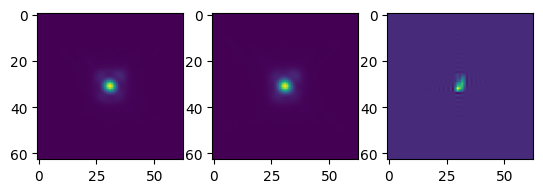

In [9]:
fig, axes = plt.subplots(1, len(psf))

for i, p in enumerate(psf):
    axes[i].imshow(p)
    
psf_filtered = psf[:2]

The following files should be located within the dataset folder (`./data/real/f_dhtau` in this example), using exactly the same names:
- `centered_im.fits`: cube
- `median_unsat.fits`: psf
- `rotnth.fits`: rotation angles

If it is the first time we run the preprocess function, it will compute PCA+ADI using VIP and then store the preprocessed data to avoid preprocessing the dataset again.

We first filter our table to maintain only the coordinates we want to fit.

In [10]:
table = table[table['snr']>15]
table

,x,y,flux,fwhm_mean,snr
0,384.839338,366.860187,278.385232,4.127939,68.267050
1,385.998693,727.507117,128.015363,4.261339,80.891019
4,548.480908,731.764102,1.652026,4.809203,19.143805


Next, we will use the first_guess function to fit our parameters

In [72]:
%%time
first_guess(table, cube, psf_filtered, 
             window_size=window_size, 
             learning_rate=1e-1, 
             epochs=1e6,
             target_folder='./logs/{}'.format(dataset_name),
             verbose=1)

[INFO] Training (x, y) = (90.98 87.35)
input shape:  (None, 90, 14, 14, 1)
Epoch 1/1000000
1/1 [==============================] - 1s 750ms/step - loss: 360.9539 - flux: 31.6014 - std: 0.1000
Epoch 2/1000000
1/1 [==============================] - 0s 242ms/step - loss: 359.3040 - flux: 31.7009 - std: 0.2000
Epoch 3/1000000
1/1 [==============================] - 0s 151ms/step - loss: 357.6552 - flux: 31.8004 - std: 0.3000
Epoch 4/1000000
1/1 [==============================] - 0s 151ms/step - loss: 356.0075 - flux: 31.8999 - std: 0.4000
Epoch 5/1000000
1/1 [==============================] - 0s 157ms/step - loss: 354.3610 - flux: 31.9995 - std: 0.5000
Epoch 6/1000000
1/1 [==============================] - 0s 153ms/step - loss: 352.7157 - flux: 32.0990 - std: 0.5999
Epoch 7/1000000
1/1 [==============================] - 0s 156ms/step - loss: 351.0716 - flux: 32.1986 - std: 0.6999
Epoch 8/1000000
1/1 [==============================] - 0s 210ms/step - loss: 349.4288 - flux: 32.2981 - std: 0.79

1/1 [==============================] - 0s 157ms/step - loss: 252.2901 - flux: 38.3362 - std: 6.8811
Epoch 71/1000000
1/1 [==============================] - 0s 149ms/step - loss: 250.8477 - flux: 38.4336 - std: 6.9748
Epoch 72/1000000
1/1 [==============================] - 0s 181ms/step - loss: 249.4109 - flux: 38.5312 - std: 7.0683
Epoch 73/1000000
1/1 [==============================] - 0s 149ms/step - loss: 247.9801 - flux: 38.6289 - std: 7.1616
Epoch 74/1000000
1/1 [==============================] - 0s 141ms/step - loss: 246.5551 - flux: 38.7269 - std: 7.2545
Epoch 75/1000000
1/1 [==============================] - 0s 154ms/step - loss: 245.1362 - flux: 38.8250 - std: 7.3472
Epoch 76/1000000
1/1 [==============================] - 0s 153ms/step - loss: 243.7234 - flux: 38.9233 - std: 7.4395
Epoch 77/1000000
1/1 [==============================] - 0s 150ms/step - loss: 242.3167 - flux: 39.0218 - std: 7.5316
Epoch 78/1000000
1/1 [==============================] - 0s 356ms/step - loss: 240

1/1 [==============================] - 0s 148ms/step - loss: 168.6832 - flux: 45.6758 - std: 12.4590
Epoch 140/1000000
1/1 [==============================] - 0s 188ms/step - loss: 167.7412 - flux: 45.7911 - std: 12.5251
Epoch 141/1000000
1/1 [==============================] - 0s 149ms/step - loss: 166.8080 - flux: 45.9067 - std: 12.5909
Epoch 142/1000000
1/1 [==============================] - 0s 154ms/step - loss: 165.8837 - flux: 46.0224 - std: 12.6562
Epoch 143/1000000
1/1 [==============================] - 0s 161ms/step - loss: 164.9684 - flux: 46.1384 - std: 12.7211
Epoch 144/1000000
1/1 [==============================] - 0s 152ms/step - loss: 164.0620 - flux: 46.2545 - std: 12.7856
Epoch 145/1000000
1/1 [==============================] - 0s 156ms/step - loss: 163.1647 - flux: 46.3708 - std: 12.8497
Epoch 146/1000000
1/1 [==============================] - 0s 362ms/step - loss: 162.2765 - flux: 46.4872 - std: 12.9133
Epoch 147/1000000
1/1 [==============================] - 0s 164ms/

Epoch 208/1000000
1/1 [==============================] - 0s 152ms/step - loss: 125.4993 - flux: 53.9185 - std: 15.9987
Epoch 209/1000000
1/1 [==============================] - 0s 352ms/step - loss: 125.1806 - flux: 54.0395 - std: 16.0338
Epoch 210/1000000
1/1 [==============================] - 0s 146ms/step - loss: 124.8691 - flux: 54.1605 - std: 16.0685
Epoch 211/1000000
1/1 [==============================] - 0s 149ms/step - loss: 124.5646 - flux: 54.2814 - std: 16.1027
Epoch 212/1000000
1/1 [==============================] - 0s 152ms/step - loss: 124.2671 - flux: 54.4023 - std: 16.1365
Epoch 213/1000000
1/1 [==============================] - 0s 155ms/step - loss: 123.9764 - flux: 54.5231 - std: 16.1698
Epoch 214/1000000
1/1 [==============================] - 0s 158ms/step - loss: 123.6924 - flux: 54.6439 - std: 16.2026
Epoch 215/1000000
1/1 [==============================] - 0s 151ms/step - loss: 123.4150 - flux: 54.7646 - std: 16.2350
Epoch 216/1000000
1/1 [=========================

1/1 [==============================] - 0s 171ms/step - loss: 115.0645 - flux: 61.9164 - std: 17.4752
Epoch 277/1000000
1/1 [==============================] - 0s 156ms/step - loss: 115.0140 - flux: 62.0292 - std: 17.4860
Epoch 278/1000000
1/1 [==============================] - 0s 170ms/step - loss: 114.9649 - flux: 62.1418 - std: 17.4965
Epoch 279/1000000
1/1 [==============================] - 0s 145ms/step - loss: 114.9172 - flux: 62.2543 - std: 17.5069
Epoch 280/1000000
1/1 [==============================] - 0s 154ms/step - loss: 114.8708 - flux: 62.3666 - std: 17.5170
Epoch 281/1000000
1/1 [==============================] - 0s 161ms/step - loss: 114.8258 - flux: 62.4787 - std: 17.5269
Epoch 282/1000000
1/1 [==============================] - 0s 172ms/step - loss: 114.7821 - flux: 62.5907 - std: 17.5366
Epoch 283/1000000
1/1 [==============================] - 0s 159ms/step - loss: 114.7396 - flux: 62.7025 - std: 17.5461
Epoch 284/1000000
1/1 [==============================] - 0s 156ms/

Epoch 345/1000000
1/1 [==============================] - 0s 154ms/step - loss: 113.4271 - flux: 69.3400 - std: 17.8563
Epoch 346/1000000
1/1 [==============================] - 0s 158ms/step - loss: 113.4162 - flux: 69.4426 - std: 17.8584
Epoch 347/1000000
1/1 [==============================] - 0s 174ms/step - loss: 113.4055 - flux: 69.5451 - std: 17.8604
Epoch 348/1000000
1/1 [==============================] - 0s 149ms/step - loss: 113.3948 - flux: 69.6474 - std: 17.8624
Epoch 349/1000000
1/1 [==============================] - 0s 179ms/step - loss: 113.3843 - flux: 69.7496 - std: 17.8644
Epoch 350/1000000
1/1 [==============================] - 0s 327ms/step - loss: 113.3738 - flux: 69.8517 - std: 17.8662
Epoch 351/1000000
1/1 [==============================] - 0s 156ms/step - loss: 113.3636 - flux: 69.9537 - std: 17.8681
Epoch 352/1000000
1/1 [==============================] - 0s 155ms/step - loss: 113.3533 - flux: 70.0555 - std: 17.8699
Epoch 353/1000000
1/1 [=========================

1/1 [==============================] - 0s 147ms/step - loss: 112.8378 - flux: 76.0392 - std: 17.9205
Epoch 414/1000000
1/1 [==============================] - 0s 147ms/step - loss: 112.8303 - flux: 76.1338 - std: 17.9207
Epoch 415/1000000
1/1 [==============================] - 0s 151ms/step - loss: 112.8228 - flux: 76.2282 - std: 17.9210
Epoch 416/1000000
1/1 [==============================] - 0s 270ms/step - loss: 112.8153 - flux: 76.3226 - std: 17.9212
Epoch 417/1000000
1/1 [==============================] - 0s 147ms/step - loss: 112.8078 - flux: 76.4168 - std: 17.9215
Epoch 418/1000000
1/1 [==============================] - 0s 140ms/step - loss: 112.8004 - flux: 76.5109 - std: 17.9217
Epoch 419/1000000
1/1 [==============================] - 0s 141ms/step - loss: 112.7929 - flux: 76.6049 - std: 17.9219
Epoch 420/1000000
1/1 [==============================] - 0s 139ms/step - loss: 112.7855 - flux: 76.6988 - std: 17.9221
Epoch 421/1000000
1/1 [==============================] - 0s 155ms/

Epoch 482/1000000
1/1 [==============================] - 0s 151ms/step - loss: 112.3494 - flux: 82.3144 - std: 17.9238
Epoch 483/1000000
1/1 [==============================] - 0s 147ms/step - loss: 112.3427 - flux: 82.4017 - std: 17.9237
Epoch 484/1000000
1/1 [==============================] - 0s 193ms/step - loss: 112.3360 - flux: 82.4889 - std: 17.9236
Epoch 485/1000000
1/1 [==============================] - 0s 153ms/step - loss: 112.3293 - flux: 82.5760 - std: 17.9235
Epoch 486/1000000
1/1 [==============================] - 0s 148ms/step - loss: 112.3227 - flux: 82.6631 - std: 17.9235
Epoch 487/1000000
1/1 [==============================] - 0s 169ms/step - loss: 112.3160 - flux: 82.7500 - std: 17.9234
Epoch 488/1000000
1/1 [==============================] - 0s 153ms/step - loss: 112.3094 - flux: 82.8368 - std: 17.9233
Epoch 489/1000000
1/1 [==============================] - 0s 151ms/step - loss: 112.3027 - flux: 82.9235 - std: 17.9232
Epoch 490/1000000
1/1 [=========================

1/1 [==============================] - 0s 153ms/step - loss: 111.9158 - flux: 88.0258 - std: 17.9161
Epoch 551/1000000
1/1 [==============================] - 0s 144ms/step - loss: 111.9098 - flux: 88.1064 - std: 17.9159
Epoch 552/1000000
1/1 [==============================] - 0s 153ms/step - loss: 111.9037 - flux: 88.1869 - std: 17.9158
Epoch 553/1000000
1/1 [==============================] - 0s 154ms/step - loss: 111.8977 - flux: 88.2673 - std: 17.9157
Epoch 554/1000000
1/1 [==============================] - 0s 153ms/step - loss: 111.8917 - flux: 88.3476 - std: 17.9155
Epoch 555/1000000
1/1 [==============================] - 0s 154ms/step - loss: 111.8857 - flux: 88.4279 - std: 17.9154
Epoch 556/1000000
1/1 [==============================] - 0s 184ms/step - loss: 111.8796 - flux: 88.5080 - std: 17.9152
Epoch 557/1000000
1/1 [==============================] - 0s 190ms/step - loss: 111.8736 - flux: 88.5880 - std: 17.9151
Epoch 558/1000000
1/1 [==============================] - 0s 152ms/

Epoch 619/1000000
1/1 [==============================] - 0s 164ms/step - loss: 111.5183 - flux: 93.3650 - std: 17.9058
Epoch 620/1000000
1/1 [==============================] - 0s 149ms/step - loss: 111.5128 - flux: 93.4391 - std: 17.9056
Epoch 621/1000000
1/1 [==============================] - 0s 215ms/step - loss: 111.5074 - flux: 93.5132 - std: 17.9054
Epoch 622/1000000
1/1 [==============================] - 0s 150ms/step - loss: 111.5019 - flux: 93.5871 - std: 17.9053
Epoch 623/1000000
1/1 [==============================] - 0s 157ms/step - loss: 111.4965 - flux: 93.6610 - std: 17.9051
Epoch 624/1000000
1/1 [==============================] - 0s 150ms/step - loss: 111.4911 - flux: 93.7347 - std: 17.9050
Epoch 625/1000000
1/1 [==============================] - 0s 149ms/step - loss: 111.4856 - flux: 93.8084 - std: 17.9048
Epoch 626/1000000
1/1 [==============================] - 0s 186ms/step - loss: 111.4802 - flux: 93.8819 - std: 17.9046
Epoch 627/1000000
1/1 [=========================

1/1 [==============================] - 0s 149ms/step - loss: 111.1652 - flux: 98.2010 - std: 17.8946
Epoch 688/1000000
1/1 [==============================] - 0s 180ms/step - loss: 111.1603 - flux: 98.2691 - std: 17.8945
Epoch 689/1000000
1/1 [==============================] - 0s 181ms/step - loss: 111.1554 - flux: 98.3371 - std: 17.8943
Epoch 690/1000000
1/1 [==============================] - 0s 148ms/step - loss: 111.1505 - flux: 98.4050 - std: 17.8941
Epoch 691/1000000
1/1 [==============================] - 0s 173ms/step - loss: 111.1456 - flux: 98.4729 - std: 17.8940
Epoch 692/1000000
1/1 [==============================] - 0s 158ms/step - loss: 111.1407 - flux: 98.5406 - std: 17.8938
Epoch 693/1000000
1/1 [==============================] - 0s 156ms/step - loss: 111.1358 - flux: 98.6083 - std: 17.8936
Epoch 694/1000000
1/1 [==============================] - 0s 149ms/step - loss: 111.1310 - flux: 98.6759 - std: 17.8935
Epoch 695/1000000
1/1 [==============================] - 0s 148ms/

1/1 [==============================] - 0s 153ms/step - loss: 110.8482 - flux: 102.6422 - std: 17.8830
Epoch 756/1000000
1/1 [==============================] - 0s 151ms/step - loss: 110.8438 - flux: 102.7047 - std: 17.8829
Epoch 757/1000000
1/1 [==============================] - 0s 152ms/step - loss: 110.8394 - flux: 102.7671 - std: 17.8827
Epoch 758/1000000
1/1 [==============================] - 0s 158ms/step - loss: 110.8350 - flux: 102.8295 - std: 17.8825
Epoch 759/1000000
1/1 [==============================] - 0s 156ms/step - loss: 110.8307 - flux: 102.8918 - std: 17.8823
Epoch 760/1000000
1/1 [==============================] - 0s 162ms/step - loss: 110.8263 - flux: 102.9540 - std: 17.8822
Epoch 761/1000000
1/1 [==============================] - 0s 159ms/step - loss: 110.8219 - flux: 103.0161 - std: 17.8820
Epoch 762/1000000
1/1 [==============================] - 0s 357ms/step - loss: 110.8175 - flux: 103.0781 - std: 17.8818
Epoch 763/1000000
1/1 [==============================] - 0

1/1 [==============================] - 0s 147ms/step - loss: 110.5651 - flux: 106.7193 - std: 17.8712
Epoch 824/1000000
1/1 [==============================] - 0s 154ms/step - loss: 110.5612 - flux: 106.7767 - std: 17.8710
Epoch 825/1000000
1/1 [==============================] - 0s 193ms/step - loss: 110.5573 - flux: 106.8340 - std: 17.8708
Epoch 826/1000000
1/1 [==============================] - 0s 193ms/step - loss: 110.5533 - flux: 106.8913 - std: 17.8706
Epoch 827/1000000
1/1 [==============================] - 0s 144ms/step - loss: 110.5494 - flux: 106.9485 - std: 17.8705
Epoch 828/1000000
1/1 [==============================] - 0s 154ms/step - loss: 110.5455 - flux: 107.0056 - std: 17.8703
Epoch 829/1000000
1/1 [==============================] - 0s 191ms/step - loss: 110.5417 - flux: 107.0626 - std: 17.8701
Epoch 830/1000000
1/1 [==============================] - 0s 151ms/step - loss: 110.5378 - flux: 107.1196 - std: 17.8699
Epoch 831/1000000
1/1 [==============================] - 0

1/1 [==============================] - 0s 165ms/step - loss: 110.3138 - flux: 110.4630 - std: 17.8592
Epoch 892/1000000
1/1 [==============================] - 0s 154ms/step - loss: 110.3103 - flux: 110.5157 - std: 17.8590
Epoch 893/1000000
1/1 [==============================] - 0s 151ms/step - loss: 110.3068 - flux: 110.5684 - std: 17.8588
Epoch 894/1000000
1/1 [==============================] - 0s 151ms/step - loss: 110.3034 - flux: 110.6210 - std: 17.8587
Epoch 895/1000000
1/1 [==============================] - 0s 153ms/step - loss: 110.2999 - flux: 110.6735 - std: 17.8585
Epoch 896/1000000
1/1 [==============================] - 0s 163ms/step - loss: 110.2965 - flux: 110.7259 - std: 17.8583
Epoch 897/1000000
1/1 [==============================] - 0s 155ms/step - loss: 110.2931 - flux: 110.7783 - std: 17.8581
Epoch 898/1000000
1/1 [==============================] - 0s 150ms/step - loss: 110.2896 - flux: 110.8306 - std: 17.8579
Epoch 899/1000000
1/1 [==============================] - 0

1/1 [==============================] - 0s 152ms/step - loss: 110.0922 - flux: 113.9012 - std: 17.8472
Epoch 960/1000000
1/1 [==============================] - 0s 150ms/step - loss: 110.0892 - flux: 113.9496 - std: 17.8470
Epoch 961/1000000
1/1 [==============================] - 0s 149ms/step - loss: 110.0862 - flux: 113.9979 - std: 17.8469
Epoch 962/1000000
1/1 [==============================] - 0s 148ms/step - loss: 110.0831 - flux: 114.0462 - std: 17.8467
Epoch 963/1000000
1/1 [==============================] - 0s 148ms/step - loss: 110.0801 - flux: 114.0944 - std: 17.8465
Epoch 964/1000000
1/1 [==============================] - 0s 142ms/step - loss: 110.0771 - flux: 114.1426 - std: 17.8463
Epoch 965/1000000
1/1 [==============================] - 0s 149ms/step - loss: 110.0740 - flux: 114.1907 - std: 17.8462
Epoch 966/1000000
1/1 [==============================] - 0s 151ms/step - loss: 110.0711 - flux: 114.2387 - std: 17.8460
Epoch 967/1000000
1/1 [==============================] - 0

1/1 [==============================] - 0s 151ms/step - loss: 109.8984 - flux: 117.0577 - std: 17.8353
Epoch 1028/1000000
1/1 [==============================] - 0s 147ms/step - loss: 109.8958 - flux: 117.1021 - std: 17.8352
Epoch 1029/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.8931 - flux: 117.1465 - std: 17.8350
Epoch 1030/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.8905 - flux: 117.1908 - std: 17.8348
Epoch 1031/1000000
1/1 [==============================] - 0s 154ms/step - loss: 109.8879 - flux: 117.2350 - std: 17.8347
Epoch 1032/1000000
1/1 [==============================] - 0s 154ms/step - loss: 109.8852 - flux: 117.2793 - std: 17.8345
Epoch 1033/1000000
1/1 [==============================] - 0s 157ms/step - loss: 109.8826 - flux: 117.3234 - std: 17.8343
Epoch 1034/1000000
1/1 [==============================] - 0s 180ms/step - loss: 109.8800 - flux: 117.3675 - std: 17.8341
Epoch 1035/1000000
1/1 [===========================

1/1 [==============================] - 0s 155ms/step - loss: 109.7325 - flux: 119.9118 - std: 17.8239
Epoch 1095/1000000
1/1 [==============================] - 0s 286ms/step - loss: 109.7303 - flux: 119.9526 - std: 17.8237
Epoch 1096/1000000
1/1 [==============================] - 0s 146ms/step - loss: 109.7280 - flux: 119.9933 - std: 17.8235
Epoch 1097/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.7257 - flux: 120.0340 - std: 17.8234
Epoch 1098/1000000
1/1 [==============================] - 0s 172ms/step - loss: 109.7234 - flux: 120.0746 - std: 17.8232
Epoch 1099/1000000
1/1 [==============================] - 0s 189ms/step - loss: 109.7211 - flux: 120.1151 - std: 17.8230
Epoch 1100/1000000
1/1 [==============================] - 0s 155ms/step - loss: 109.7188 - flux: 120.1556 - std: 17.8228
Epoch 1101/1000000
1/1 [==============================] - 0s 187ms/step - loss: 109.7166 - flux: 120.1960 - std: 17.8227
Epoch 1102/1000000
1/1 [===========================

1/1 [==============================] - 0s 148ms/step - loss: 109.5894 - flux: 122.5280 - std: 17.8127
Epoch 1162/1000000
1/1 [==============================] - 0s 149ms/step - loss: 109.5875 - flux: 122.5654 - std: 17.8125
Epoch 1163/1000000
1/1 [==============================] - 0s 147ms/step - loss: 109.5855 - flux: 122.6026 - std: 17.8123
Epoch 1164/1000000
1/1 [==============================] - 0s 175ms/step - loss: 109.5835 - flux: 122.6398 - std: 17.8122
Epoch 1165/1000000
1/1 [==============================] - 0s 151ms/step - loss: 109.5816 - flux: 122.6770 - std: 17.8120
Epoch 1166/1000000
1/1 [==============================] - 0s 155ms/step - loss: 109.5796 - flux: 122.7141 - std: 17.8118
Epoch 1167/1000000
1/1 [==============================] - 0s 147ms/step - loss: 109.5777 - flux: 122.7512 - std: 17.8117
Epoch 1168/1000000
1/1 [==============================] - 0s 151ms/step - loss: 109.5757 - flux: 122.7882 - std: 17.8115
Epoch 1169/1000000
1/1 [===========================

1/1 [==============================] - 0s 152ms/step - loss: 109.4670 - flux: 124.9200 - std: 17.8018
Epoch 1229/1000000
1/1 [==============================] - 0s 150ms/step - loss: 109.4653 - flux: 124.9541 - std: 17.8017
Epoch 1230/1000000
1/1 [==============================] - 0s 148ms/step - loss: 109.4637 - flux: 124.9881 - std: 17.8015
Epoch 1231/1000000
1/1 [==============================] - 0s 146ms/step - loss: 109.4620 - flux: 125.0221 - std: 17.8014
Epoch 1232/1000000
1/1 [==============================] - 0s 144ms/step - loss: 109.4603 - flux: 125.0560 - std: 17.8012
Epoch 1233/1000000
1/1 [==============================] - 0s 196ms/step - loss: 109.4586 - flux: 125.0899 - std: 17.8010
Epoch 1234/1000000
1/1 [==============================] - 0s 149ms/step - loss: 109.4570 - flux: 125.1237 - std: 17.8009
Epoch 1235/1000000
1/1 [==============================] - 0s 152ms/step - loss: 109.4553 - flux: 125.1575 - std: 17.8007
Epoch 1236/1000000
1/1 [===========================

1/1 [==============================] - 0s 271ms/step - loss: 109.3632 - flux: 127.1001 - std: 17.7914
Epoch 1296/1000000
1/1 [==============================] - 0s 179ms/step - loss: 109.3617 - flux: 127.1311 - std: 17.7913
Epoch 1297/1000000
1/1 [==============================] - 0s 155ms/step - loss: 109.3603 - flux: 127.1620 - std: 17.7911
Epoch 1298/1000000
1/1 [==============================] - 0s 151ms/step - loss: 109.3589 - flux: 127.1929 - std: 17.7910
Epoch 1299/1000000
1/1 [==============================] - 0s 157ms/step - loss: 109.3575 - flux: 127.2238 - std: 17.7908
Epoch 1300/1000000
1/1 [==============================] - 0s 177ms/step - loss: 109.3561 - flux: 127.2546 - std: 17.7907
Epoch 1301/1000000
1/1 [==============================] - 0s 156ms/step - loss: 109.3547 - flux: 127.2854 - std: 17.7905
Epoch 1302/1000000
1/1 [==============================] - 0s 176ms/step - loss: 109.3533 - flux: 127.3161 - std: 17.7904
Epoch 1303/1000000
1/1 [===========================

1/1 [==============================] - 0s 159ms/step - loss: 109.2759 - flux: 129.0796 - std: 17.7816
Epoch 1363/1000000
1/1 [==============================] - 0s 152ms/step - loss: 109.2747 - flux: 129.1076 - std: 17.7814
Epoch 1364/1000000
1/1 [==============================] - 0s 170ms/step - loss: 109.2735 - flux: 129.1357 - std: 17.7813
Epoch 1365/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.2723 - flux: 129.1637 - std: 17.7812
Epoch 1366/1000000
1/1 [==============================] - 0s 160ms/step - loss: 109.2711 - flux: 129.1916 - std: 17.7810
Epoch 1367/1000000
1/1 [==============================] - 0s 163ms/step - loss: 109.2699 - flux: 129.2195 - std: 17.7809
Epoch 1368/1000000
1/1 [==============================] - 0s 156ms/step - loss: 109.2688 - flux: 129.2474 - std: 17.7807
Epoch 1369/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.2676 - flux: 129.2753 - std: 17.7806
Epoch 1370/1000000
1/1 [===========================

1/1 [==============================] - 0s 192ms/step - loss: 109.2031 - flux: 130.8694 - std: 17.7723
Epoch 1430/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.2021 - flux: 130.8947 - std: 17.7721
Epoch 1431/1000000
1/1 [==============================] - 0s 149ms/step - loss: 109.2011 - flux: 130.9200 - std: 17.7720
Epoch 1432/1000000
1/1 [==============================] - 0s 203ms/step - loss: 109.2001 - flux: 130.9452 - std: 17.7719
Epoch 1433/1000000
1/1 [==============================] - 0s 187ms/step - loss: 109.1991 - flux: 130.9704 - std: 17.7717
Epoch 1434/1000000
1/1 [==============================] - 0s 158ms/step - loss: 109.1982 - flux: 130.9956 - std: 17.7716
Epoch 1435/1000000
1/1 [==============================] - 0s 152ms/step - loss: 109.1972 - flux: 131.0208 - std: 17.7715
Epoch 1436/1000000
1/1 [==============================] - 0s 166ms/step - loss: 109.1962 - flux: 131.0459 - std: 17.7713
Epoch 1437/1000000
1/1 [===========================

1/1 [==============================] - 0s 151ms/step - loss: 109.1429 - flux: 132.4803 - std: 17.7636
Epoch 1497/1000000
1/1 [==============================] - 0s 179ms/step - loss: 109.1421 - flux: 132.5031 - std: 17.7635
Epoch 1498/1000000
1/1 [==============================] - 0s 157ms/step - loss: 109.1413 - flux: 132.5258 - std: 17.7633
Epoch 1499/1000000
1/1 [==============================] - 0s 159ms/step - loss: 109.1405 - flux: 132.5485 - std: 17.7632
Epoch 1500/1000000
1/1 [==============================] - 0s 141ms/step - loss: 109.1397 - flux: 132.5711 - std: 17.7631
Epoch 1501/1000000
1/1 [==============================] - 0s 198ms/step - loss: 109.1389 - flux: 132.5937 - std: 17.7630
Epoch 1502/1000000
1/1 [==============================] - 0s 171ms/step - loss: 109.1381 - flux: 132.6162 - std: 17.7629
Epoch 1503/1000000
1/1 [==============================] - 0s 152ms/step - loss: 109.1373 - flux: 132.6388 - std: 17.7627
Epoch 1504/1000000
1/1 [===========================

1/1 [==============================] - 0s 351ms/step - loss: 109.0936 - flux: 133.9233 - std: 17.7556
Epoch 1564/1000000
1/1 [==============================] - 0s 365ms/step - loss: 109.0930 - flux: 133.9436 - std: 17.7554
Epoch 1565/1000000
1/1 [==============================] - 0s 151ms/step - loss: 109.0923 - flux: 133.9639 - std: 17.7553
Epoch 1566/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.0917 - flux: 133.9842 - std: 17.7552
Epoch 1567/1000000
1/1 [==============================] - 0s 161ms/step - loss: 109.0910 - flux: 134.0044 - std: 17.7551
Epoch 1568/1000000
1/1 [==============================] - 0s 157ms/step - loss: 109.0903 - flux: 134.0246 - std: 17.7550
Epoch 1569/1000000
1/1 [==============================] - 0s 148ms/step - loss: 109.0897 - flux: 134.0447 - std: 17.7549
Epoch 1570/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.0890 - flux: 134.0648 - std: 17.7548
Epoch 1571/1000000
1/1 [===========================

1/1 [==============================] - 0s 165ms/step - loss: 109.0536 - flux: 135.2093 - std: 17.7482
Epoch 1631/1000000
1/1 [==============================] - 0s 174ms/step - loss: 109.0531 - flux: 135.2273 - std: 17.7481
Epoch 1632/1000000
1/1 [==============================] - 0s 157ms/step - loss: 109.0525 - flux: 135.2454 - std: 17.7480
Epoch 1633/1000000
1/1 [==============================] - 0s 148ms/step - loss: 109.0520 - flux: 135.2634 - std: 17.7479
Epoch 1634/1000000
1/1 [==============================] - 0s 150ms/step - loss: 109.0515 - flux: 135.2813 - std: 17.7478
Epoch 1635/1000000
1/1 [==============================] - 0s 185ms/step - loss: 109.0509 - flux: 135.2993 - std: 17.7476
Epoch 1636/1000000
1/1 [==============================] - 0s 147ms/step - loss: 109.0504 - flux: 135.3171 - std: 17.7475
Epoch 1637/1000000
1/1 [==============================] - 0s 152ms/step - loss: 109.0499 - flux: 135.3350 - std: 17.7474
Epoch 1638/1000000
1/1 [===========================

1/1 [==============================] - 0s 149ms/step - loss: 109.0214 - flux: 136.3493 - std: 17.7415
Epoch 1698/1000000
1/1 [==============================] - 0s 148ms/step - loss: 109.0209 - flux: 136.3652 - std: 17.7414
Epoch 1699/1000000
1/1 [==============================] - 0s 175ms/step - loss: 109.0205 - flux: 136.3811 - std: 17.7413
Epoch 1700/1000000
1/1 [==============================] - 0s 192ms/step - loss: 109.0201 - flux: 136.3970 - std: 17.7412
Epoch 1701/1000000
1/1 [==============================] - 0s 151ms/step - loss: 109.0197 - flux: 136.4129 - std: 17.7411
Epoch 1702/1000000
1/1 [==============================] - 0s 153ms/step - loss: 109.0192 - flux: 136.4288 - std: 17.7410
Epoch 1703/1000000
1/1 [==============================] - 0s 151ms/step - loss: 109.0188 - flux: 136.4446 - std: 17.7409
Epoch 1704/1000000
1/1 [==============================] - 0s 152ms/step - loss: 109.0184 - flux: 136.4604 - std: 17.7408
Epoch 1705/1000000
1/1 [===========================

1/1 [==============================] - 0s 313ms/step - loss: 108.9956 - flux: 137.3544 - std: 17.7354
Epoch 1765/1000000
1/1 [==============================] - 0s 206ms/step - loss: 108.9953 - flux: 137.3684 - std: 17.7353
Epoch 1766/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9949 - flux: 137.3824 - std: 17.7352
Epoch 1767/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9946 - flux: 137.3964 - std: 17.7351
Epoch 1768/1000000
1/1 [==============================] - 0s 147ms/step - loss: 108.9942 - flux: 137.4104 - std: 17.7350
Epoch 1769/1000000
1/1 [==============================] - 0s 158ms/step - loss: 108.9939 - flux: 137.4243 - std: 17.7350
Epoch 1770/1000000
1/1 [==============================] - 0s 157ms/step - loss: 108.9936 - flux: 137.4382 - std: 17.7349
Epoch 1771/1000000
1/1 [==============================] - 0s 146ms/step - loss: 108.9932 - flux: 137.4521 - std: 17.7348
Epoch 1772/1000000
1/1 [===========================

1/1 [==============================] - 0s 155ms/step - loss: 108.9752 - flux: 138.2357 - std: 17.7299
Epoch 1832/1000000
1/1 [==============================] - 0s 155ms/step - loss: 108.9749 - flux: 138.2480 - std: 17.7299
Epoch 1833/1000000
1/1 [==============================] - 0s 159ms/step - loss: 108.9747 - flux: 138.2602 - std: 17.7298
Epoch 1834/1000000
1/1 [==============================] - 0s 169ms/step - loss: 108.9744 - flux: 138.2725 - std: 17.7297
Epoch 1835/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9741 - flux: 138.2847 - std: 17.7296
Epoch 1836/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9739 - flux: 138.2968 - std: 17.7296
Epoch 1837/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9736 - flux: 138.3090 - std: 17.7295
Epoch 1838/1000000
1/1 [==============================] - 0s 148ms/step - loss: 108.9734 - flux: 138.3211 - std: 17.7294
Epoch 1839/1000000
1/1 [===========================

1/1 [==============================] - 0s 353ms/step - loss: 108.9592 - flux: 139.0042 - std: 17.7251
Epoch 1899/1000000
1/1 [==============================] - 0s 167ms/step - loss: 108.9590 - flux: 139.0149 - std: 17.7251
Epoch 1900/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9587 - flux: 139.0255 - std: 17.7250
Epoch 1901/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9585 - flux: 139.0361 - std: 17.7249
Epoch 1902/1000000
1/1 [==============================] - 0s 184ms/step - loss: 108.9583 - flux: 139.0468 - std: 17.7248
Epoch 1903/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9581 - flux: 139.0573 - std: 17.7248
Epoch 1904/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9579 - flux: 139.0679 - std: 17.7247
Epoch 1905/1000000
1/1 [==============================] - 0s 143ms/step - loss: 108.9577 - flux: 139.0784 - std: 17.7246
Epoch 1906/1000000
1/1 [===========================

1/1 [==============================] - 0s 158ms/step - loss: 108.9467 - flux: 139.6705 - std: 17.7209
Epoch 1966/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9465 - flux: 139.6798 - std: 17.7208
Epoch 1967/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9463 - flux: 139.6890 - std: 17.7207
Epoch 1968/1000000
1/1 [==============================] - 0s 146ms/step - loss: 108.9462 - flux: 139.6982 - std: 17.7207
Epoch 1969/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9460 - flux: 139.7073 - std: 17.7206
Epoch 1970/1000000
1/1 [==============================] - 0s 198ms/step - loss: 108.9458 - flux: 139.7165 - std: 17.7206
Epoch 1971/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9457 - flux: 139.7256 - std: 17.7205
Epoch 1972/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9455 - flux: 139.7347 - std: 17.7204
Epoch 1973/1000000
1/1 [===========================

1/1 [==============================] - 0s 185ms/step - loss: 108.9370 - flux: 140.2450 - std: 17.7171
Epoch 2033/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9368 - flux: 140.2530 - std: 17.7171
Epoch 2034/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9367 - flux: 140.2609 - std: 17.7170
Epoch 2035/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9366 - flux: 140.2688 - std: 17.7170
Epoch 2036/1000000
1/1 [==============================] - 0s 146ms/step - loss: 108.9364 - flux: 140.2766 - std: 17.7169
Epoch 2037/1000000
1/1 [==============================] - 0s 365ms/step - loss: 108.9363 - flux: 140.2845 - std: 17.7169
Epoch 2038/1000000
1/1 [==============================] - 0s 155ms/step - loss: 108.9362 - flux: 140.2923 - std: 17.7168
Epoch 2039/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9361 - flux: 140.3002 - std: 17.7168
Epoch 2040/1000000
1/1 [===========================

1/1 [==============================] - 0s 149ms/step - loss: 108.9295 - flux: 140.7375 - std: 17.7139
Epoch 2100/1000000
1/1 [==============================] - 0s 156ms/step - loss: 108.9294 - flux: 140.7443 - std: 17.7139
Epoch 2101/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9293 - flux: 140.7511 - std: 17.7138
Epoch 2102/1000000
1/1 [==============================] - 0s 144ms/step - loss: 108.9292 - flux: 140.7578 - std: 17.7138
Epoch 2103/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9291 - flux: 140.7646 - std: 17.7137
Epoch 2104/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9290 - flux: 140.7713 - std: 17.7137
Epoch 2105/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9289 - flux: 140.7780 - std: 17.7136
Epoch 2106/1000000
1/1 [==============================] - 0s 362ms/step - loss: 108.9288 - flux: 140.7847 - std: 17.7136
Epoch 2107/1000000
1/1 [===========================

1/1 [==============================] - 0s 194ms/step - loss: 108.9238 - flux: 141.1574 - std: 17.7111
Epoch 2167/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9237 - flux: 141.1632 - std: 17.7111
Epoch 2168/1000000
1/1 [==============================] - 0s 157ms/step - loss: 108.9237 - flux: 141.1690 - std: 17.7110
Epoch 2169/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9236 - flux: 141.1747 - std: 17.7110
Epoch 2170/1000000
1/1 [==============================] - 0s 194ms/step - loss: 108.9235 - flux: 141.1804 - std: 17.7110
Epoch 2171/1000000
1/1 [==============================] - 0s 145ms/step - loss: 108.9234 - flux: 141.1861 - std: 17.7109
Epoch 2172/1000000
1/1 [==============================] - 0s 172ms/step - loss: 108.9234 - flux: 141.1918 - std: 17.7109
Epoch 2173/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9233 - flux: 141.1975 - std: 17.7108
Epoch 2174/1000000
1/1 [===========================

1/1 [==============================] - 0s 340ms/step - loss: 108.9195 - flux: 141.5134 - std: 17.7087
Epoch 2234/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9194 - flux: 141.5183 - std: 17.7087
Epoch 2235/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9194 - flux: 141.5231 - std: 17.7086
Epoch 2236/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9193 - flux: 141.5280 - std: 17.7086
Epoch 2237/1000000
1/1 [==============================] - 0s 159ms/step - loss: 108.9193 - flux: 141.5328 - std: 17.7086
Epoch 2238/1000000
1/1 [==============================] - 0s 157ms/step - loss: 108.9192 - flux: 141.5376 - std: 17.7085
Epoch 2239/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9192 - flux: 141.5424 - std: 17.7085
Epoch 2240/1000000
1/1 [==============================] - 0s 193ms/step - loss: 108.9191 - flux: 141.5472 - std: 17.7085
Epoch 2241/1000000
1/1 [===========================

1/1 [==============================] - 0s 378ms/step - loss: 108.9162 - flux: 141.8135 - std: 17.7067
Epoch 2301/1000000
1/1 [==============================] - 0s 141ms/step - loss: 108.9162 - flux: 141.8176 - std: 17.7066
Epoch 2302/1000000
1/1 [==============================] - 0s 156ms/step - loss: 108.9161 - flux: 141.8217 - std: 17.7066
Epoch 2303/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9161 - flux: 141.8257 - std: 17.7066
Epoch 2304/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9161 - flux: 141.8298 - std: 17.7066
Epoch 2305/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9160 - flux: 141.8339 - std: 17.7065
Epoch 2306/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9160 - flux: 141.8379 - std: 17.7065
Epoch 2307/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9159 - flux: 141.8419 - std: 17.7065
Epoch 2308/1000000
1/1 [===========================

1/1 [==============================] - 0s 152ms/step - loss: 108.9138 - flux: 142.0652 - std: 17.7050
Epoch 2368/1000000
1/1 [==============================] - 0s 145ms/step - loss: 108.9137 - flux: 142.0686 - std: 17.7049
Epoch 2369/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9137 - flux: 142.0720 - std: 17.7049
Epoch 2370/1000000
1/1 [==============================] - 0s 163ms/step - loss: 108.9137 - flux: 142.0754 - std: 17.7049
Epoch 2371/1000000
1/1 [==============================] - 0s 159ms/step - loss: 108.9137 - flux: 142.0788 - std: 17.7049
Epoch 2372/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9136 - flux: 142.0822 - std: 17.7048
Epoch 2373/1000000
1/1 [==============================] - 0s 169ms/step - loss: 108.9136 - flux: 142.0855 - std: 17.7048
Epoch 2374/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9136 - flux: 142.0889 - std: 17.7048
Epoch 2375/1000000
1/1 [===========================

1/1 [==============================] - 0s 151ms/step - loss: 108.9120 - flux: 142.2750 - std: 17.7035
Epoch 2435/1000000
1/1 [==============================] - 0s 156ms/step - loss: 108.9119 - flux: 142.2779 - std: 17.7035
Epoch 2436/1000000
1/1 [==============================] - 0s 192ms/step - loss: 108.9119 - flux: 142.2807 - std: 17.7035
Epoch 2437/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9119 - flux: 142.2835 - std: 17.7035
Epoch 2438/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9119 - flux: 142.2864 - std: 17.7034
Epoch 2439/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9118 - flux: 142.2892 - std: 17.7034
Epoch 2440/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9118 - flux: 142.2920 - std: 17.7034
Epoch 2441/1000000
1/1 [==============================] - 0s 191ms/step - loss: 108.9118 - flux: 142.2948 - std: 17.7034
Epoch 2442/1000000
1/1 [===========================

1/1 [==============================] - 0s 149ms/step - loss: 108.9106 - flux: 142.4492 - std: 17.7023
Epoch 2502/1000000
1/1 [==============================] - 0s 147ms/step - loss: 108.9106 - flux: 142.4515 - std: 17.7023
Epoch 2503/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9106 - flux: 142.4539 - std: 17.7023
Epoch 2504/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9105 - flux: 142.4562 - std: 17.7023
Epoch 2505/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9105 - flux: 142.4585 - std: 17.7022
Epoch 2506/1000000
1/1 [==============================] - 0s 169ms/step - loss: 108.9105 - flux: 142.4608 - std: 17.7022
Epoch 2507/1000000
1/1 [==============================] - 0s 144ms/step - loss: 108.9105 - flux: 142.4632 - std: 17.7022
Epoch 2508/1000000
1/1 [==============================] - 0s 271ms/step - loss: 108.9105 - flux: 142.4655 - std: 17.7022
Epoch 2509/1000000
1/1 [===========================

1/1 [==============================] - 0s 149ms/step - loss: 108.9096 - flux: 142.5929 - std: 17.7013
Epoch 2569/1000000
1/1 [==============================] - 0s 147ms/step - loss: 108.9096 - flux: 142.5948 - std: 17.7013
Epoch 2570/1000000
1/1 [==============================] - 0s 171ms/step - loss: 108.9096 - flux: 142.5967 - std: 17.7013
Epoch 2571/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9096 - flux: 142.5987 - std: 17.7013
Epoch 2572/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9095 - flux: 142.6006 - std: 17.7012
Epoch 2573/1000000
1/1 [==============================] - 0s 369ms/step - loss: 108.9095 - flux: 142.6025 - std: 17.7012
Epoch 2574/1000000
1/1 [==============================] - 0s 331ms/step - loss: 108.9095 - flux: 142.6044 - std: 17.7012
Epoch 2575/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9095 - flux: 142.6063 - std: 17.7012
Epoch 2576/1000000
1/1 [===========================

1/1 [==============================] - 0s 150ms/step - loss: 108.9089 - flux: 142.7109 - std: 17.7005
Epoch 2636/1000000
1/1 [==============================] - 0s 156ms/step - loss: 108.9089 - flux: 142.7125 - std: 17.7005
Epoch 2637/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9088 - flux: 142.7140 - std: 17.7005
Epoch 2638/1000000
1/1 [==============================] - 0s 155ms/step - loss: 108.9088 - flux: 142.7156 - std: 17.7004
Epoch 2639/1000000
1/1 [==============================] - 0s 150ms/step - loss: 108.9088 - flux: 142.7172 - std: 17.7004
Epoch 2640/1000000
1/1 [==============================] - 0s 156ms/step - loss: 108.9088 - flux: 142.7188 - std: 17.7004
Epoch 2641/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9088 - flux: 142.7203 - std: 17.7004
Epoch 2642/1000000
1/1 [==============================] - 0s 334ms/step - loss: 108.9088 - flux: 142.7219 - std: 17.7004
Epoch 2643/1000000
1/1 [===========================

1/1 [==============================] - 0s 149ms/step - loss: 108.9083 - flux: 142.8073 - std: 17.6998
Epoch 2703/1000000
1/1 [==============================] - 0s 141ms/step - loss: 108.9083 - flux: 142.8086 - std: 17.6998
Epoch 2704/1000000
1/1 [==============================] - 0s 173ms/step - loss: 108.9083 - flux: 142.8099 - std: 17.6998
Epoch 2705/1000000
1/1 [==============================] - 0s 148ms/step - loss: 108.9083 - flux: 142.8112 - std: 17.6998
Epoch 2706/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9083 - flux: 142.8125 - std: 17.6998
Epoch 2707/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9083 - flux: 142.8138 - std: 17.6997
Epoch 2708/1000000
1/1 [==============================] - 0s 148ms/step - loss: 108.9083 - flux: 142.8150 - std: 17.6997
Epoch 2709/1000000
1/1 [==============================] - 0s 173ms/step - loss: 108.9083 - flux: 142.8163 - std: 17.6997
Epoch 2710/1000000
1/1 [===========================

1/1 [==============================] - 0s 142ms/step - loss: 108.9079 - flux: 142.8857 - std: 17.6992
Epoch 2770/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9079 - flux: 142.8868 - std: 17.6992
Epoch 2771/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9079 - flux: 142.8878 - std: 17.6992
Epoch 2772/1000000
1/1 [==============================] - 0s 176ms/step - loss: 108.9079 - flux: 142.8889 - std: 17.6992
Epoch 2773/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9079 - flux: 142.8899 - std: 17.6992
Epoch 2774/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9079 - flux: 142.8909 - std: 17.6992
Epoch 2775/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9079 - flux: 142.8920 - std: 17.6992
Epoch 2776/1000000
1/1 [==============================] - 0s 160ms/step - loss: 108.9079 - flux: 142.8930 - std: 17.6992
Epoch 2777/1000000
1/1 [===========================

1/1 [==============================] - 0s 186ms/step - loss: 108.9077 - flux: 142.9492 - std: 17.6988
Epoch 2837/1000000
1/1 [==============================] - 0s 153ms/step - loss: 108.9077 - flux: 142.9500 - std: 17.6988
Epoch 2838/1000000
1/1 [==============================] - 0s 168ms/step - loss: 108.9076 - flux: 142.9509 - std: 17.6988
Epoch 2839/1000000
1/1 [==============================] - 0s 174ms/step - loss: 108.9076 - flux: 142.9517 - std: 17.6988
Epoch 2840/1000000
1/1 [==============================] - 0s 165ms/step - loss: 108.9076 - flux: 142.9526 - std: 17.6988
Epoch 2841/1000000
1/1 [==============================] - 0s 156ms/step - loss: 108.9076 - flux: 142.9534 - std: 17.6988
Epoch 2842/1000000
1/1 [==============================] - 0s 156ms/step - loss: 108.9076 - flux: 142.9542 - std: 17.6988
Epoch 2843/1000000
1/1 [==============================] - 0s 183ms/step - loss: 108.9076 - flux: 142.9551 - std: 17.6987
Epoch 2844/1000000
1/1 [===========================

1/1 [==============================] - 0s 160ms/step - loss: 108.9075 - flux: 143.0003 - std: 17.6984
Epoch 2904/1000000
1/1 [==============================] - 0s 318ms/step - loss: 108.9075 - flux: 143.0010 - std: 17.6984
Epoch 2905/1000000
1/1 [==============================] - 0s 163ms/step - loss: 108.9075 - flux: 143.0017 - std: 17.6984
Epoch 2906/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9074 - flux: 143.0023 - std: 17.6984
Epoch 2907/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9074 - flux: 143.0030 - std: 17.6984
Epoch 2908/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9074 - flux: 143.0037 - std: 17.6984
Epoch 2909/1000000
1/1 [==============================] - 0s 148ms/step - loss: 108.9074 - flux: 143.0044 - std: 17.6984
Epoch 2910/1000000
1/1 [==============================] - 0s 152ms/step - loss: 108.9074 - flux: 143.0050 - std: 17.6984
Epoch 2911/1000000
1/1 [===========================

1/1 [==============================] - 0s 152ms/step - loss: 108.9073 - flux: 143.0413 - std: 17.6981
Epoch 2971/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9073 - flux: 143.0418 - std: 17.6981
Epoch 2972/1000000
1/1 [==============================] - 0s 148ms/step - loss: 108.9073 - flux: 143.0424 - std: 17.6981
Epoch 2973/1000000
1/1 [==============================] - 0s 167ms/step - loss: 108.9073 - flux: 143.0429 - std: 17.6981
Epoch 2974/1000000
1/1 [==============================] - 0s 163ms/step - loss: 108.9073 - flux: 143.0435 - std: 17.6981
Epoch 2975/1000000
1/1 [==============================] - 0s 194ms/step - loss: 108.9073 - flux: 143.0440 - std: 17.6981
Epoch 2976/1000000
1/1 [==============================] - 0s 164ms/step - loss: 108.9073 - flux: 143.0445 - std: 17.6981
Epoch 2977/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9073 - flux: 143.0451 - std: 17.6981
Epoch 2978/1000000
1/1 [===========================

1/1 [==============================] - 0s 167ms/step - loss: 108.9072 - flux: 143.0740 - std: 17.6979
Epoch 3038/1000000
1/1 [==============================] - 0s 248ms/step - loss: 108.9072 - flux: 143.0745 - std: 17.6979
Epoch 3039/1000000
1/1 [==============================] - 0s 148ms/step - loss: 108.9072 - flux: 143.0749 - std: 17.6979
Epoch 3040/1000000
1/1 [==============================] - 0s 148ms/step - loss: 108.9072 - flux: 143.0753 - std: 17.6979
Epoch 3041/1000000
1/1 [==============================] - 0s 168ms/step - loss: 108.9072 - flux: 143.0757 - std: 17.6979
Epoch 3042/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9072 - flux: 143.0762 - std: 17.6979
Epoch 3043/1000000
1/1 [==============================] - 0s 149ms/step - loss: 108.9072 - flux: 143.0766 - std: 17.6979
Epoch 3044/1000000
1/1 [==============================] - 0s 174ms/step - loss: 108.9072 - flux: 143.0770 - std: 17.6979
Epoch 3045/1000000
1/1 [===========================

1/1 [==============================] - 0s 155ms/step - loss: 108.9072 - flux: 143.1000 - std: 17.6977
Epoch 3105/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9072 - flux: 143.1004 - std: 17.6977
Epoch 3106/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9071 - flux: 143.1007 - std: 17.6977
Epoch 3107/1000000
1/1 [==============================] - 0s 154ms/step - loss: 108.9071 - flux: 143.1011 - std: 17.6977
Epoch 3108/1000000
1/1 [==============================] - 0s 158ms/step - loss: 108.9071 - flux: 143.1014 - std: 17.6977
Epoch 3109/1000000
1/1 [==============================] - 0s 155ms/step - loss: 108.9071 - flux: 143.1017 - std: 17.6977
Epoch 3110/1000000
1/1 [==============================] - 0s 159ms/step - loss: 108.9071 - flux: 143.1021 - std: 17.6977
Epoch 3111/1000000
1/1 [==============================] - 0s 151ms/step - loss: 108.9071 - flux: 143.1024 - std: 17.6977
Epoch 3112/1000000
1/1 [===========================

,x,y,flux,fwhm_mean,snr,optimal_flux
1,90.979734,87.349372,31.502232,4.559094,4.930584,143.113495


## Visualizing results

In [253]:
from core.engine import inference_step

In [254]:
index = 1
model_path = f'./logs/{dataset_name}/model_{index}/'

In [255]:
table_op = pd.read_csv(os.path.join(model_path, '..', 'prediction.csv'))
table_op

,x,y,flux,fwhm_mean,snr,optimal_flux
0,385.998693,727.507117,128.015363,4.261339,80.891019,148.931488


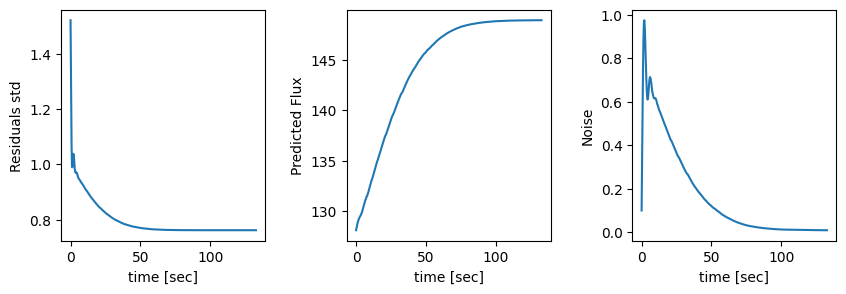

In [256]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3),
                         gridspec_kw={'hspace': 0, 'wspace': 0.4})

ylabels = ['Residuals std', 'Predicted Flux', 'Noise']
for i, metric in enumerate(['epoch_loss', 'epoch_flux', 'epoch_std']):
    train_metrics = get_metrics(f'{model_path}/logs/train/', show_keys=False, metric_name=metric)
    
    time = (train_metrics['wall_time'].values -train_metrics['wall_time'].values[0]) 
    axes[i].plot(time, train_metrics['value'].values)
    axes[i].set_xlabel('time [sec]')
    axes[i].set_ylabel(ylabels[i])


In [258]:
fake_comp, real_comp, fluxes, model = inference_step(cube, 
                                                     psf_filtered, 
                                                     table_op.iloc[0]['x'], 
                                                     table_op.iloc[0]['y'], 
                                                     model_path=model_path, 
                                                     window_size=window_size)

input shape:  (None, 80, 14, 14, 1)
1/1 [==============================] - 0s 332ms/step


In [259]:
shift_coords = model.trainable_variables[-1]

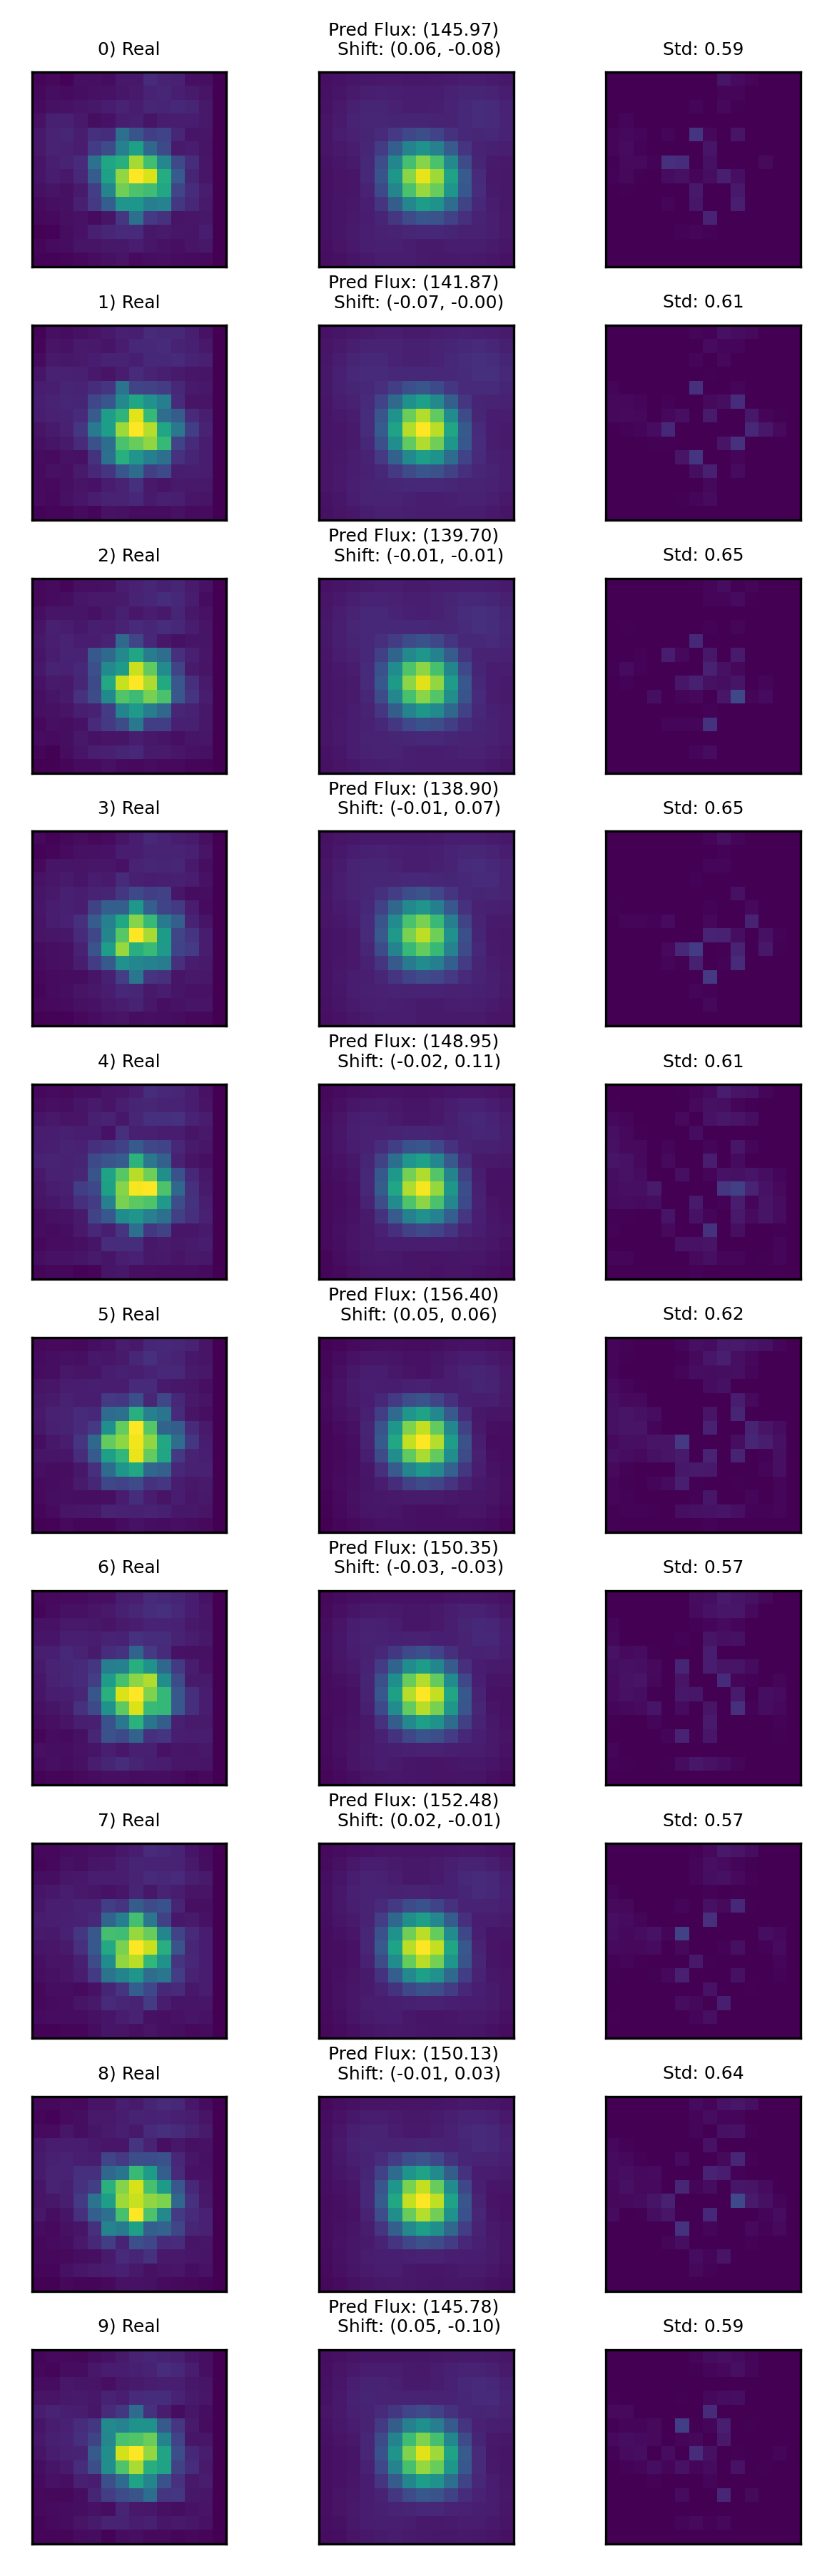

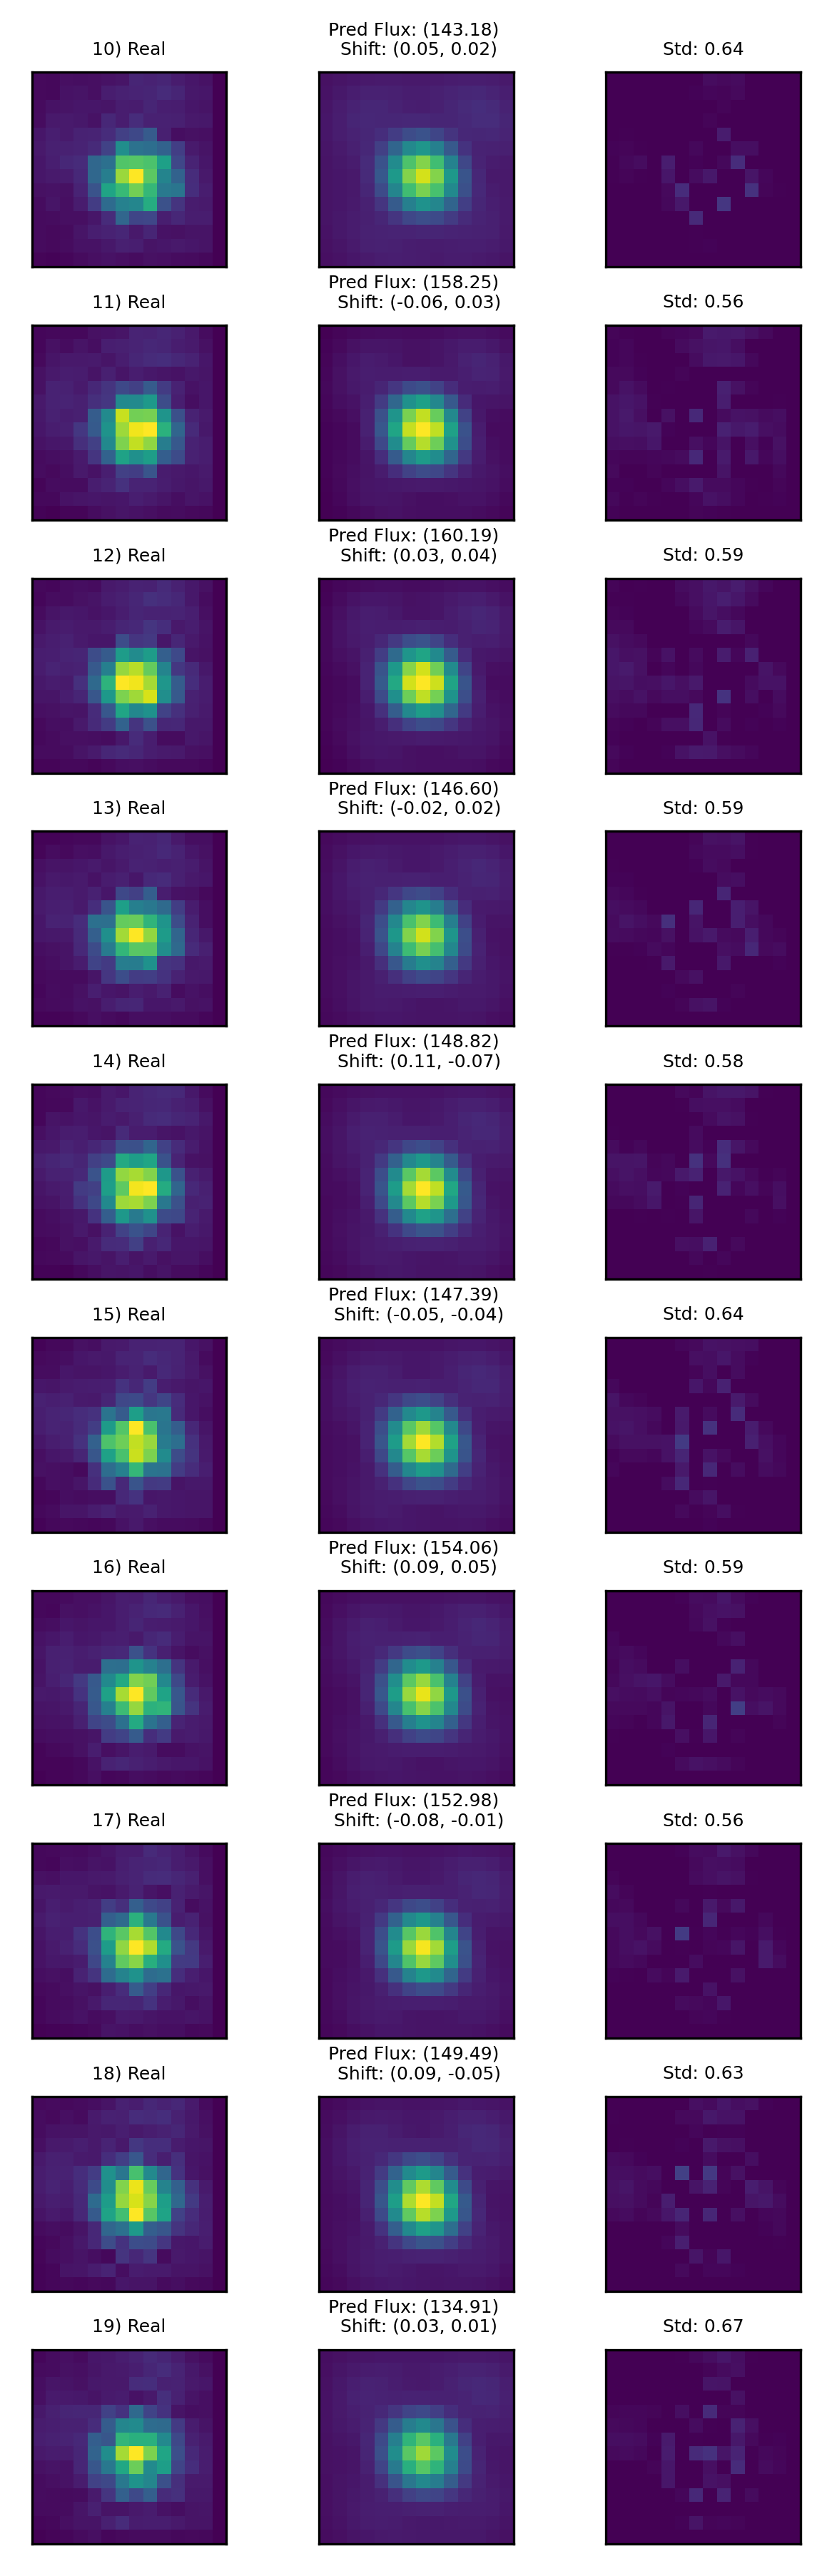

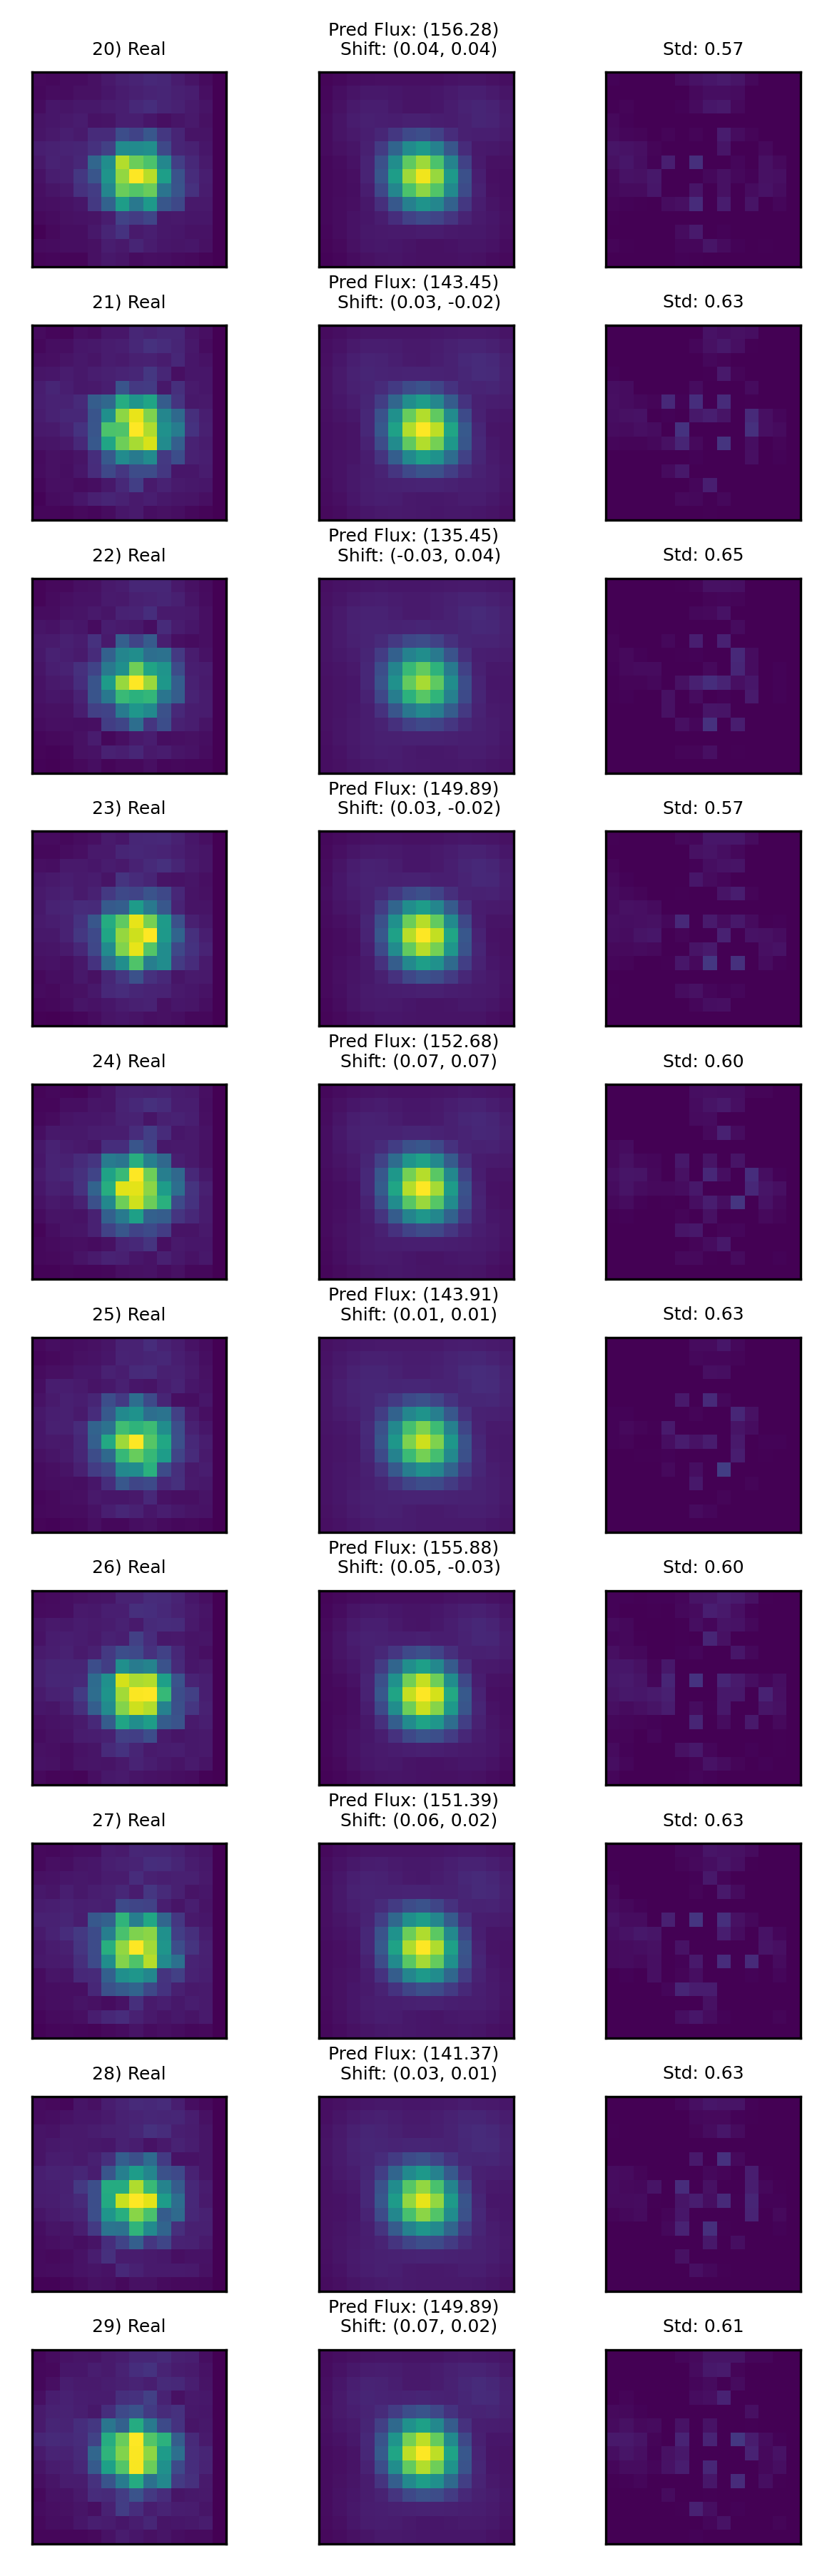

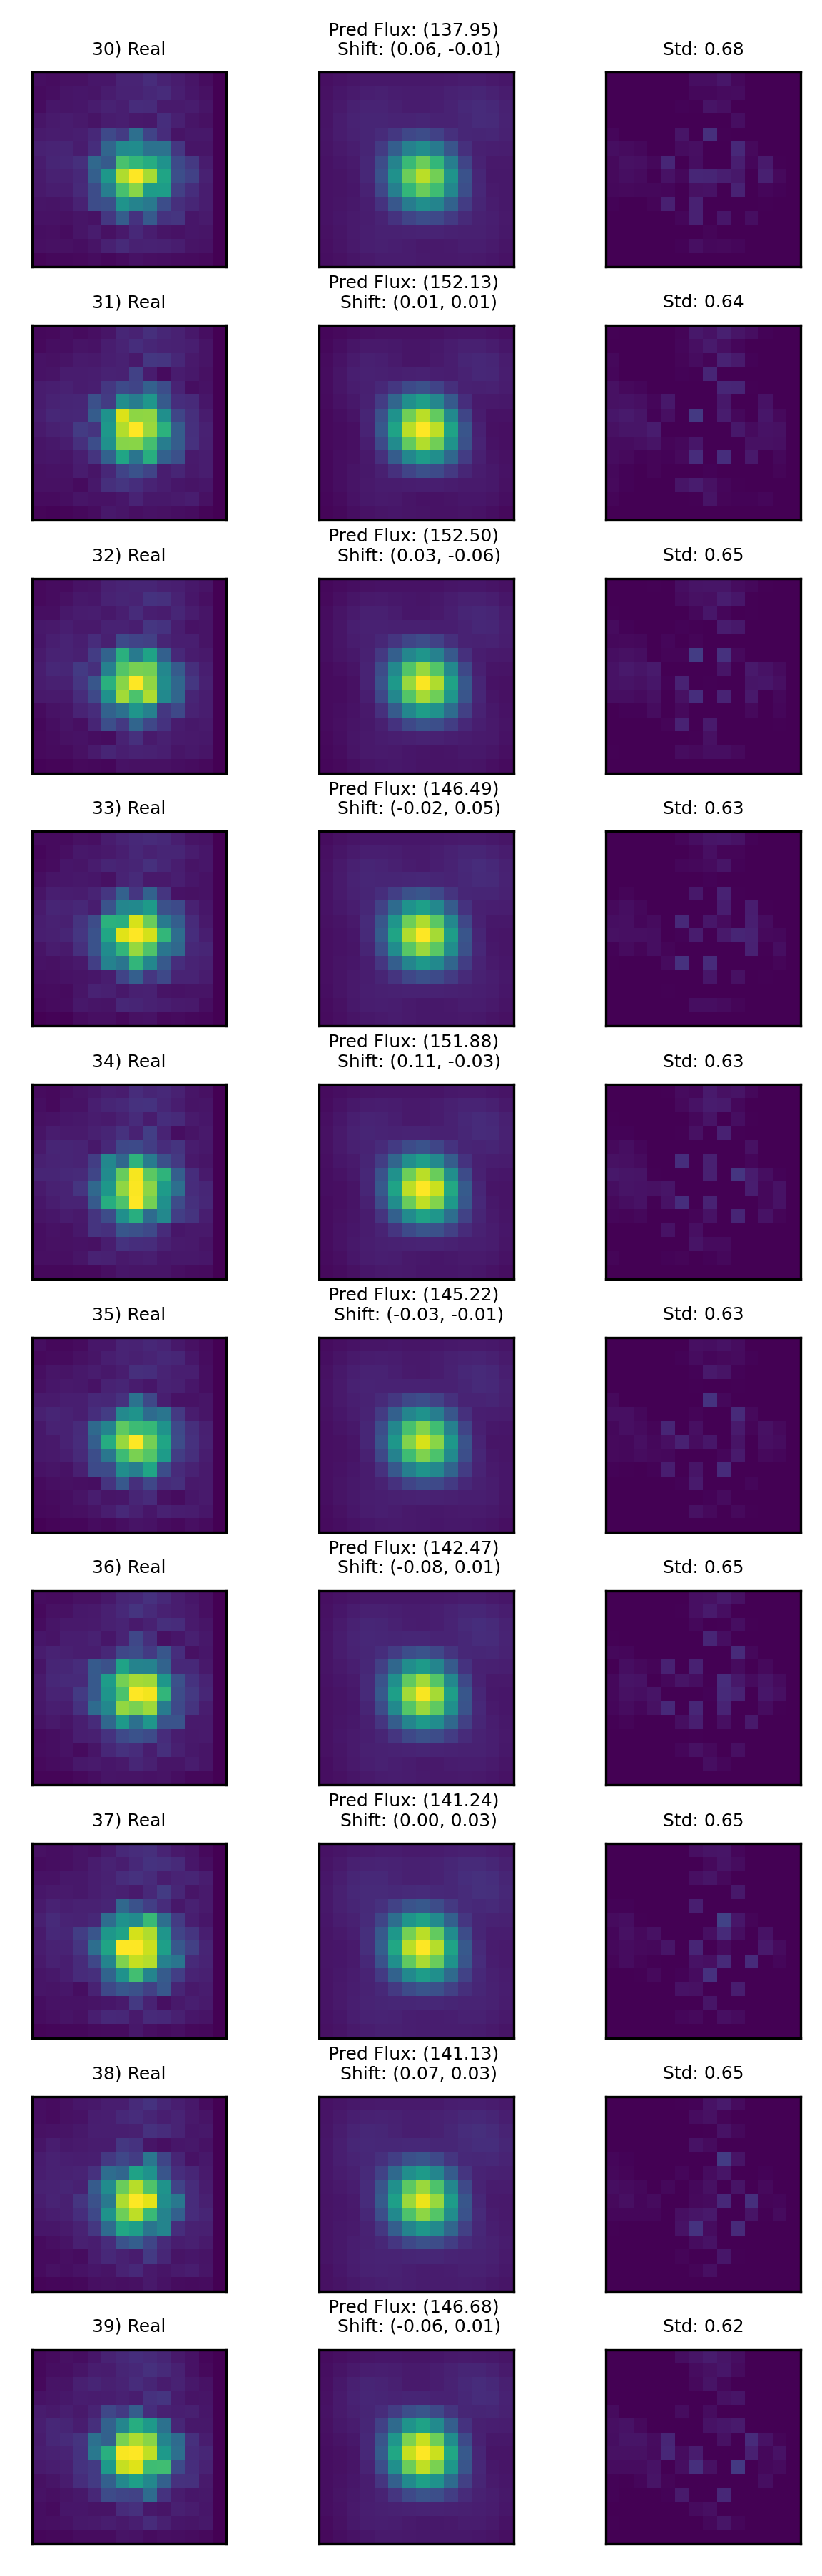

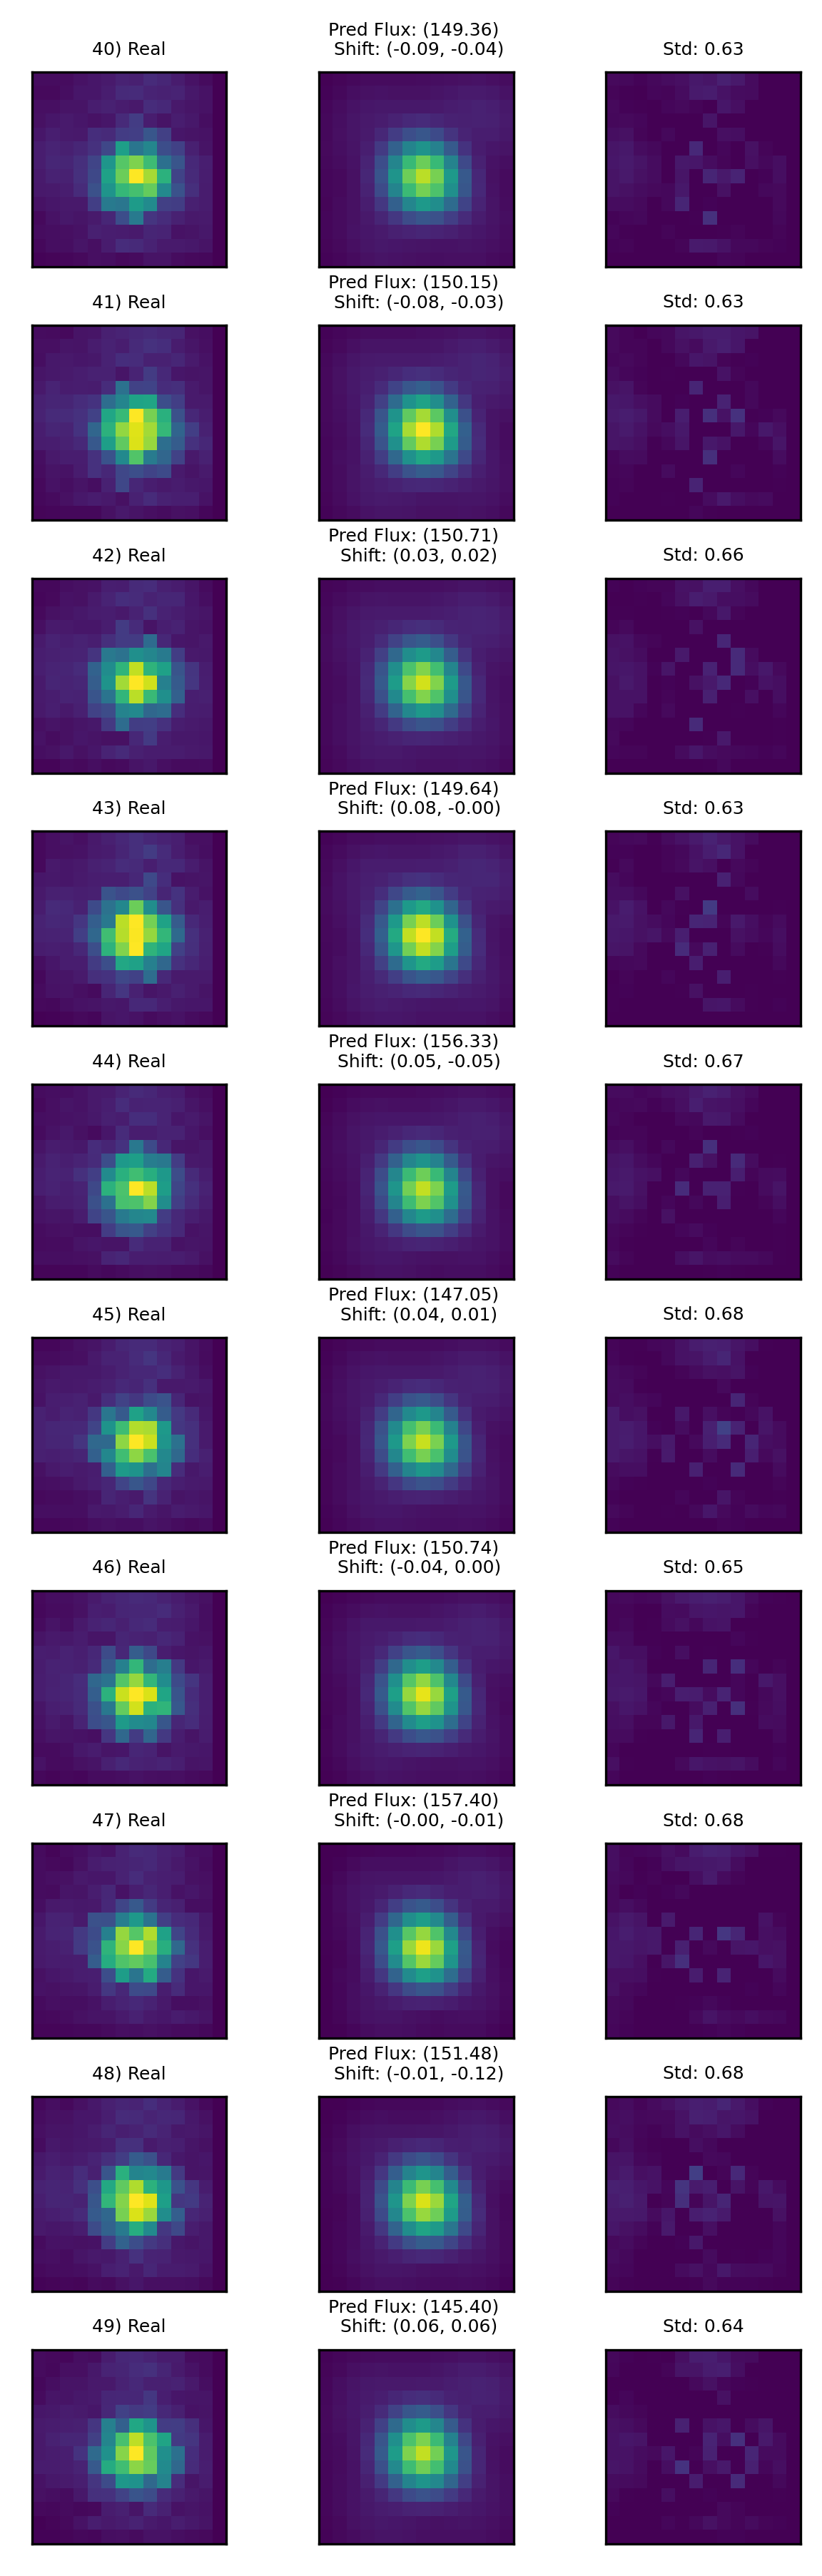

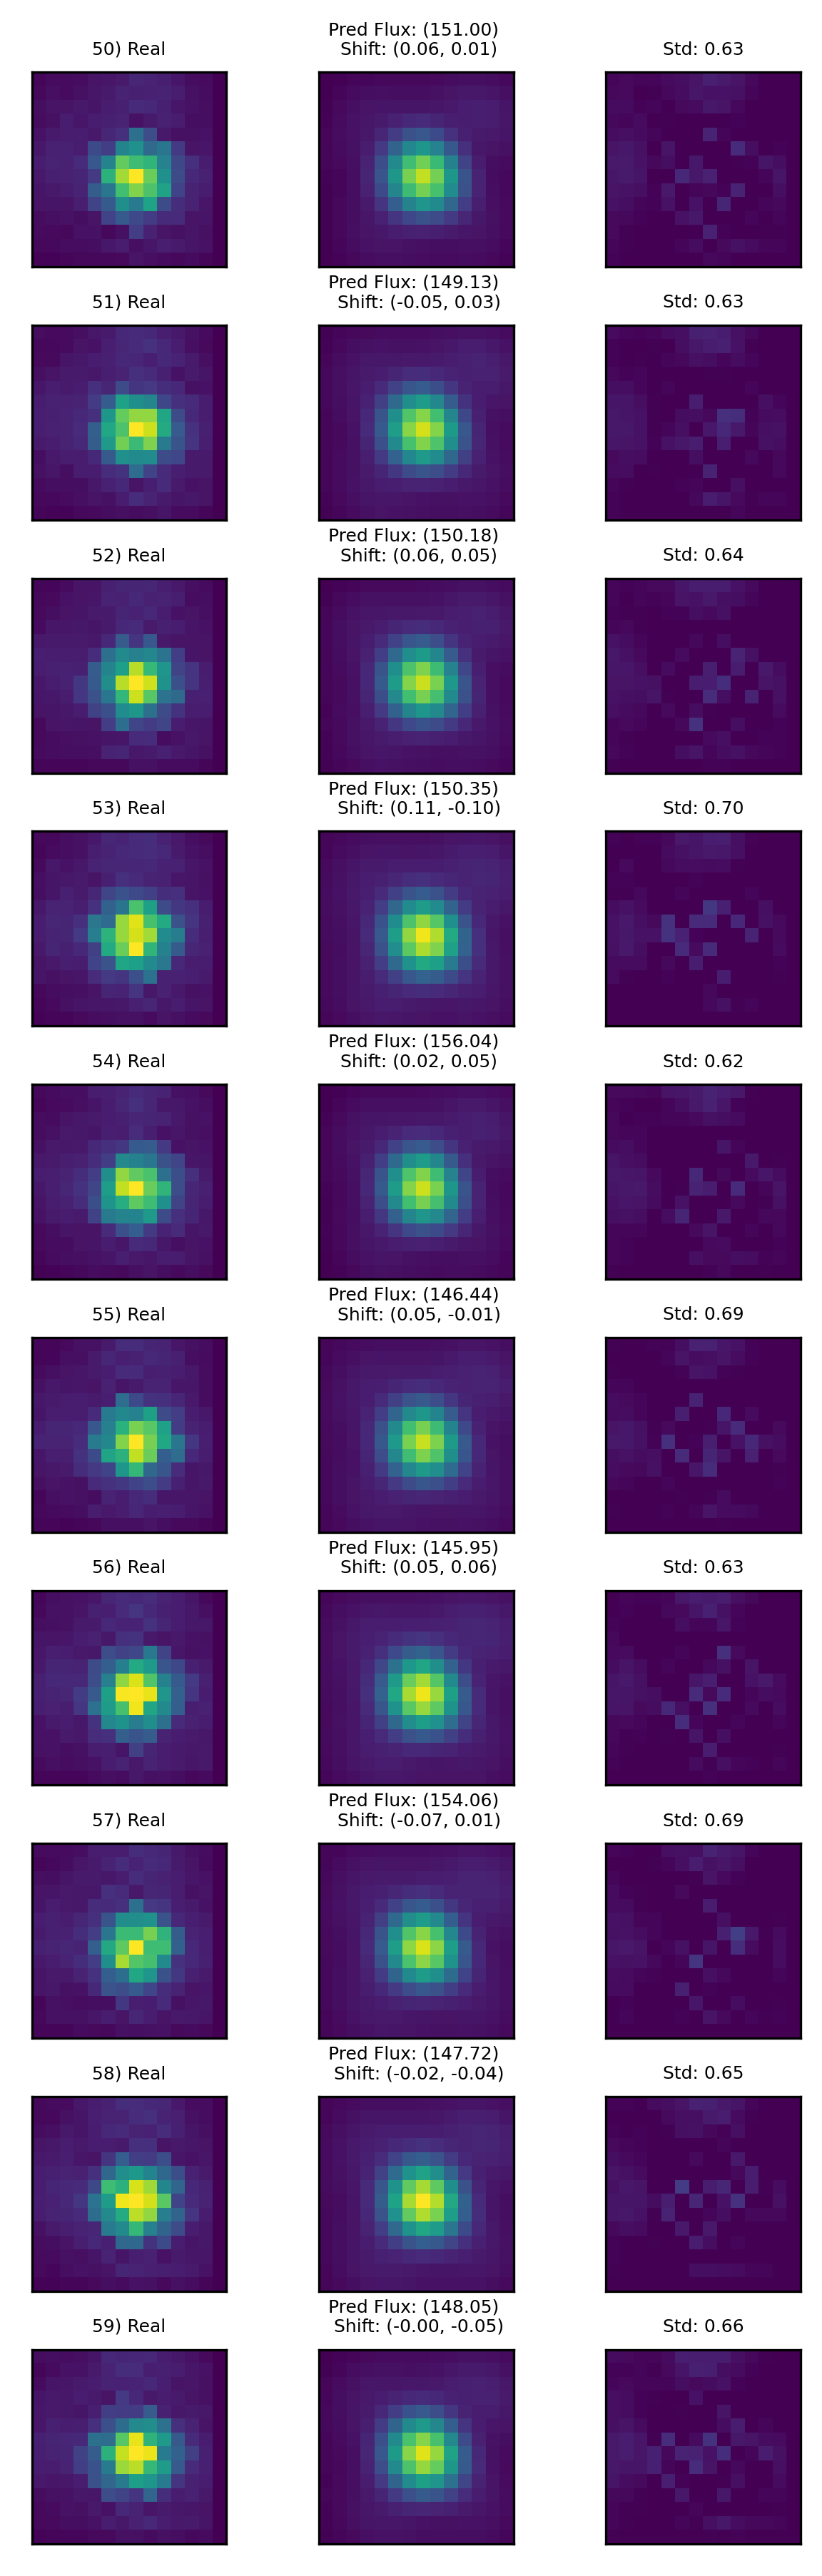

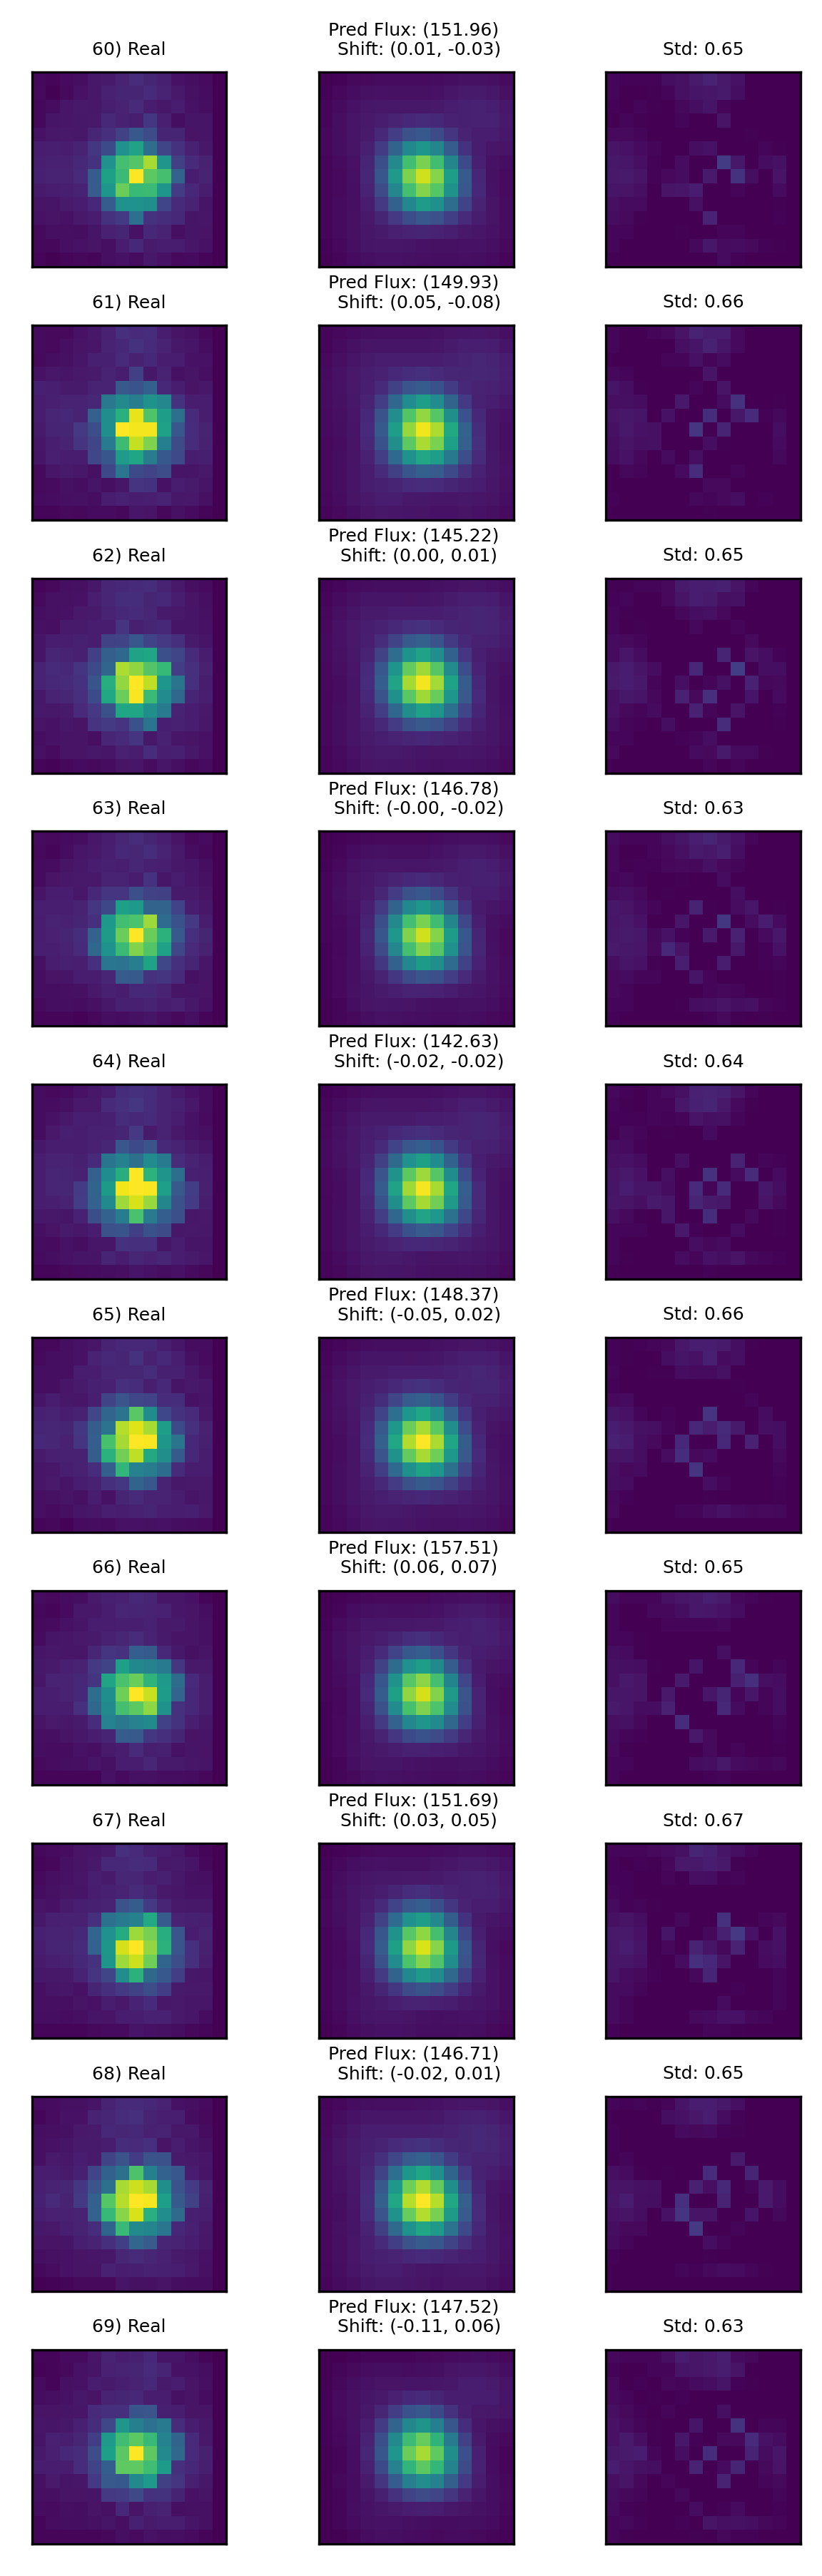

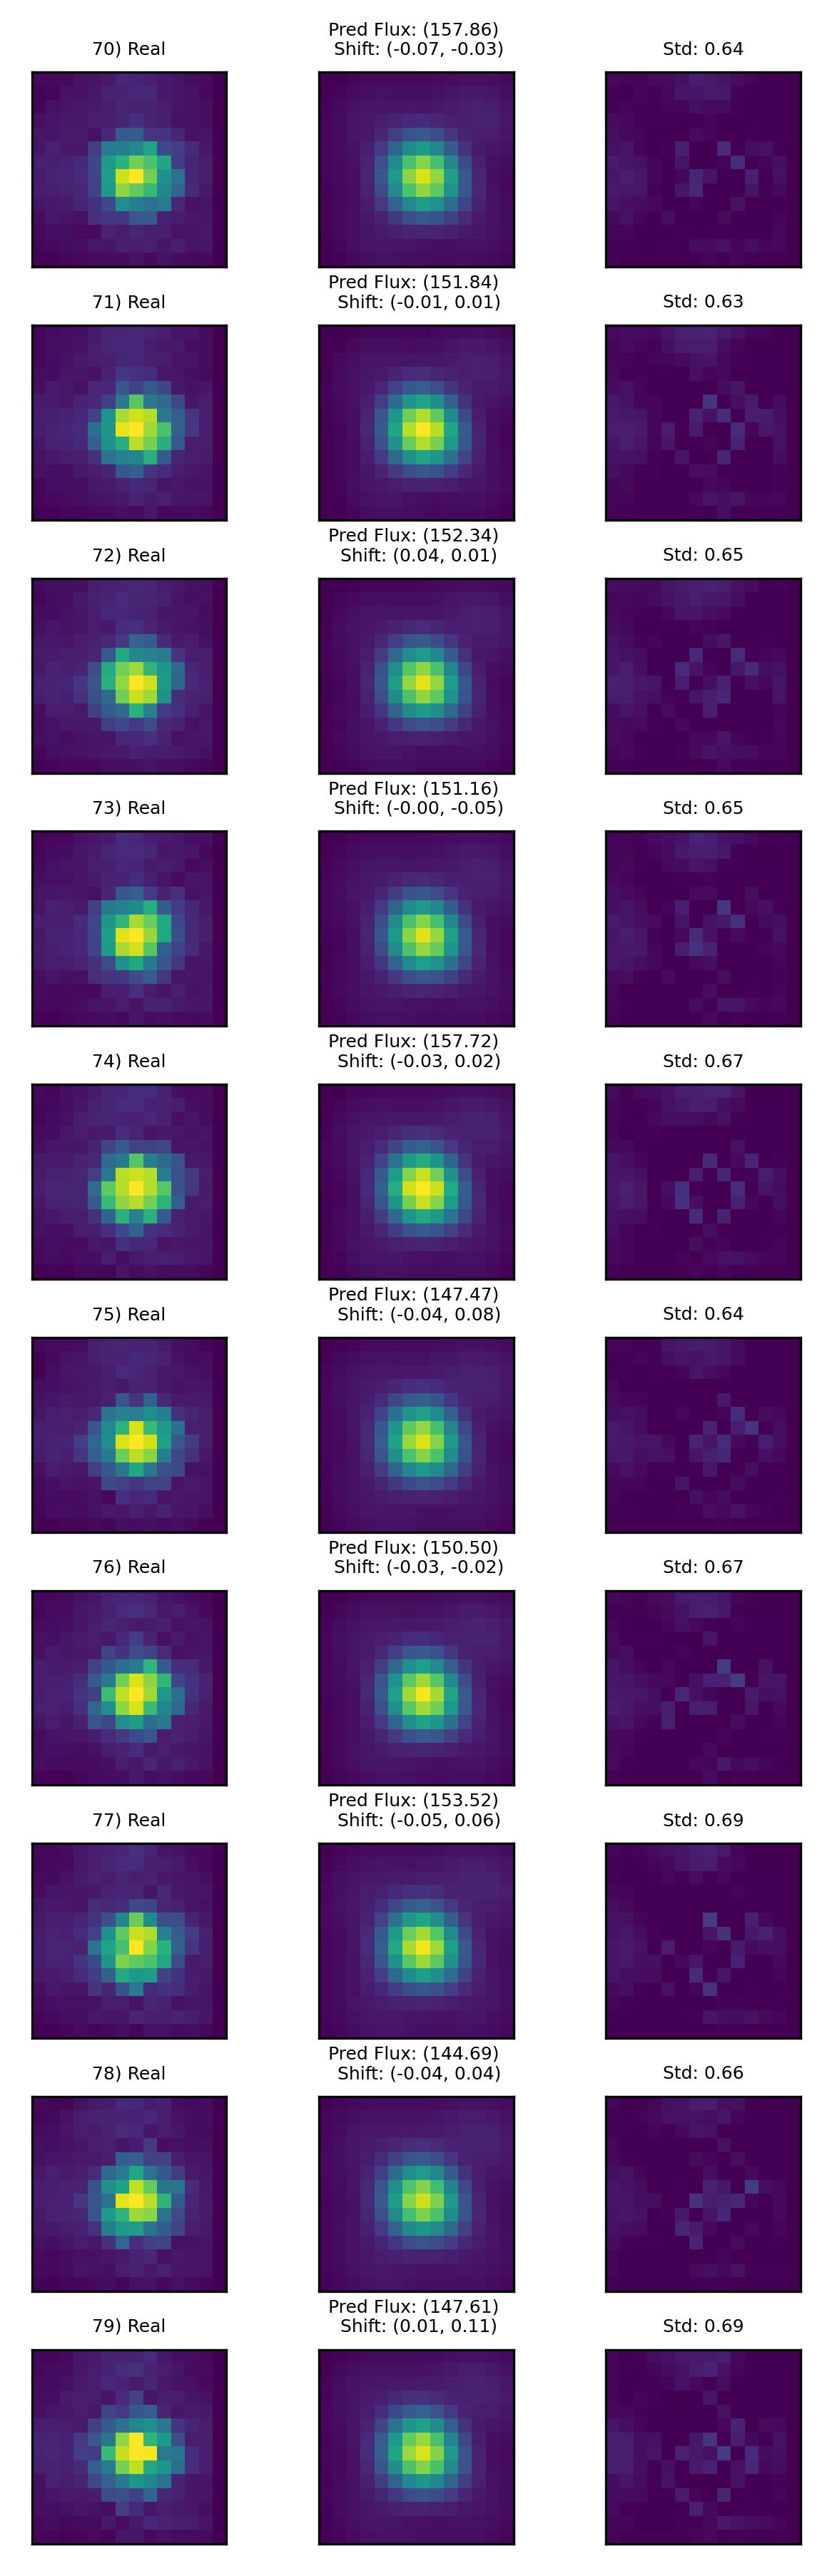

In [260]:
Ntotal = 10
fs = 6
pivots = np.arange(0, fake_comp.shape[0], Ntotal)

os.makedirs(os.path.join(model_path, 'results'), exist_ok=True)
for start in pivots:
    
    fig, axes = plt.subplots(Ntotal, 3, dpi=300, figsize=(15, 15),sharex=True, sharey=True,
                            gridspec_kw={'hspace': 0.3, 'wspace': -0.85})


    for i, N in enumerate(range(start, start+Ntotal)):

        vmin = real_comp[N].min()
        vmax = real_comp[N].max()

        axes[i][0].imshow(real_comp[N], vmin=vmin, vmax=vmax)
        axes[i][0].set_title(f'{N}) Real', fontsize=fs)

        axes[i][1].imshow(fake_comp[N], vmin=vmin, vmax=vmax)
        axes[i][1].set_title('Pred Flux: ({:.2f}) \n Shift: ({:.2f}, {:.2f})'.format(fluxes[N], 
                                                                              shift_coords[N][0],
                                                                              shift_coords[N][1]), fontsize=fs)

        residuals = real_comp[N]-fake_comp[N]
        im = axes[i][2].imshow(residuals, vmin=vmin, vmax=vmax)
        axes[i][2].set_title('Std: {:.2f}'.format(np.std(residuals)), fontsize=fs)

        axes[i][0].set_xticks([])
        axes[i][0].set_yticks([])
    
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.58, 0.12, 0.01, 0.75])
#     cbar_ax.tick_params(labelsize=fs)
#     fig.colorbar(im, cax=cbar_ax)
#     fig.savefig(os.path.join(model_path, 'results', f'{start}.pdf'), format='pdf', bbox_inches='tight')

# Visualizing on whole image 

In [292]:
from vip_hci.preproc.derotation import cube_derotate
from vip_hci.fm import cube_inject_companions
from vip_hci.config import VLT_SPHERE_IFS
from vip_hci.psfsub import pca

from core.engine import get_angle_radius, pca_tf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
table_opt = pd.read_csv(os.path.join(model_path,'..','prediction.csv'))
table_opt

,x,y,flux,fwhm_mean,snr,optimal_flux
0,385.998693,727.507117,128.015363,4.261339,80.891019,148.931488


In [263]:
mean_dxdy = np.mean(shift_coords, 0)

mean_x = table_opt['x'].values[0] + mean_dxdy[0] 
mean_y = table_opt['y'].values[0] + mean_dxdy[1]
mean_flux = table_opt['optimal_flux'].values[0]

mean_x, mean_y

(386.00669339716114, 727.511439430269)

In [264]:
mean_radius, mean_theta = get_angle_radius(mean_x, 
                                           mean_y,
                                           width=cube.shape[-1],
                                           height=cube.shape[-2])
mean_radius, mean_theta

(250.0010601971086, 119.99808841599852)

In [298]:
cube_rot = cube_derotate(cube, rot_angles, nproc=4, imlib='opencv', interpolation='nearneig')

fake_cube = np.zeros_like(cube_rot)
injected = cube_inject_companions(fake_cube, 
                                  psf[0], 
                                  rot_angles, 
                                  flevel=-mean_flux,
                                  plsc=VLT_SPHERE_IFS['plsc'], 
                                  rad_dists=[mean_radius], 
                                  n_branches=1,          
                                  theta=mean_theta)

Branch 1:
	(X,Y)=(386.01, 727.51) at 1.85 arcsec (250.00 pxs from center)


In [299]:
%%time
pca_fake = pca_tf(injected, 
                  out_size=cube_rot.shape, 
                  rot_ang=rot_angles,
                  ncomp=1)

CPU times: user 10.3 s, sys: 2.23 s, total: 12.5 s
Wall time: 4.48 s


In [307]:
%%time
pca_real = pca_tf(cube_rot, 
                  out_size=cube_rot.shape, 
                  rot_ang=-rot_angles,
                  ncomp=1)

CPU times: user 11.8 s, sys: 1.94 s, total: 13.8 s
Wall time: 4.56 s


In [308]:
pca_real.shape

TensorShape([1023, 1023])

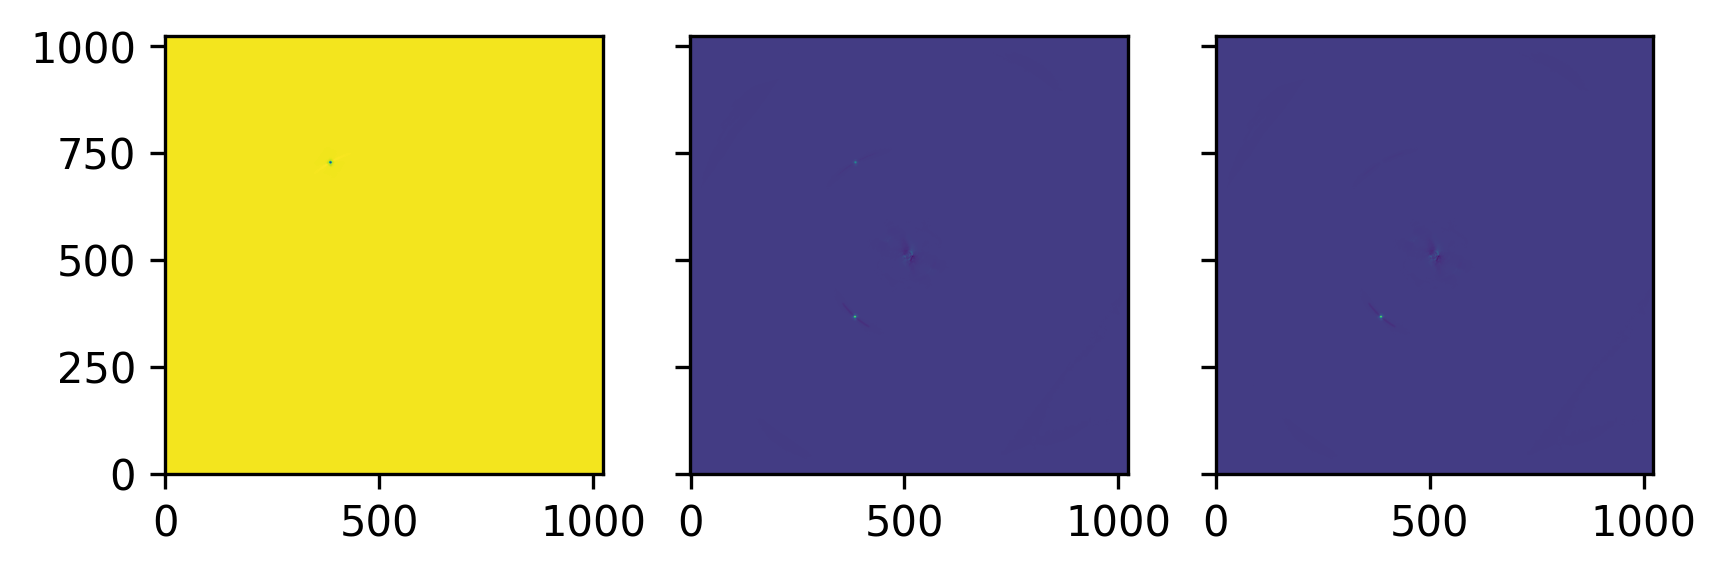

In [314]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,
                        dpi=300)
axes[0].imshow(pca_fake, origin='lower')

axes[1].imshow(pca_real, origin='lower')

axes[2].imshow(pca_real+pca_fake, origin='lower')